In [13]:
import cryptpandas
dp1 = cryptpandas.read_encrypted(path="./release_3547.crypt", password='oUFtGMsMEEyPCCP6')
dp1 = dp1.fillna(0)
dp1


strat_0   strat_1   strat_2   strat_3   strat_4   strat_5   strat_6  \
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    -1.045104  0.000000  0.000000  0.000000  0.000000  0.139780  1.481773   
2    -0.229267  0.000000  0.000000  0.000000  0.000000  0.109780  0.731916   
3    -0.332475  0.000000 -0.056052  0.000000  0.000000 -0.038044 -0.557418   
4    -0.827446  0.000000 -0.349031  0.000000  0.000000 -0.035166 -1.177777   
...        ...       ...       ...       ...       ...       ...       ...   
3543 -0.381309 -0.212961  0.501306  0.322370 -0.103106 -0.557941 -0.020194   
3544  0.620255  0.064530  0.391176 -0.679921 -1.709302  1.486581  0.246001   
3545  0.224598  0.413439  0.376754 -1.812926 -1.050624  0.827850  0.575480   
3546 -0.519673 -0.923652 -0.969943 -1.200744 -1.621024 -0.776032 -1.095705   
3547 -0.054196 -0.073748 -0.315726 -1.033543 -0.608461  0.306113  0.490871   

       strat_7   strat_8   strat_9  ...  strat_12  strat_13  strat_14  \
0     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1     0.000000  1.298774  0.000000  ...  0.000000  0.000000  0.000000   
2     0.000000  1.748748  0.000000  ...  0.000000  0.000000  0.000000   
3    -0.246940  0.043789  0.000000  ...  0.000000  0.000000  0.000000   
4    -0.795178 -1.105112  0.000000  ...  0.000000  0.000000  0.000000   
...        ...       ...       ...  ...       ...       ...       ...   
3543 -0.008013 -0.355781 -0.881419  ...  0.096630  0.679358  0.193971   
3544 -0.131926  0.878312  0.535155  ... -0.538533  0.895913  0.201795   
3545 -1.391991  0.693199  0.626953  ...  0.822201  1.718395 -0.151103   
3546  0.621262 -0.606028 -1.556457  ...  0.139280 -0.344232  0.560597   
3547 -0.607191  0.271265 -0.401861  ...  0.590406 -0.366171 -0.426450   

      strat_15  strat_16  strat_17  strat_18  strat_19  strat_20  strat_21  
0     0.000000 -1.216100  0.000000  0.000000  0.000000  0.000000  0.000000  
1    -3.467195  1.344721 -0.175514  0.000000  0.000000  0.000000 -0.827335  
2    -1.709005  0.681587 -0.235082 -1.271263  0.000000  0.000000 -0.121570  
3     0.506470 -0.403906  0.249474 -0.151417 -0.253624  0.000000 -1.002791  
4     0.370537 -0.813284  0.143559  0.391880 -0.888127  0.000000  0.233682  
...        ...       ...       ...       ...       ...       ...       ...  
3543 -0.011222 -0.224635 -0.192642  0.206517  0.198630  0.295600  1.135041  
3544  0.012643  0.309842 -0.007732 -0.657715 -0.205288 -0.786703 -0.074781  
3545 -0.000421  0.083085 -0.103815 -0.328812 -1.100259 -0.219447 -1.173045  
3546 -0.006781 -0.723691  0.092065  0.281789  0.697799  0.301284  0.997957  
3547  0.005347  0.247545 -0.701139  0.014518 -0.552265 -0.063815 -0.896698  

[3548 rows x 22 columns]

In [14]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Assuming dp1 is your DataFrame with strategy returns

# Calculate mean returns and covariance matrix
mean_returns = dp1.mean() / 100  # Convert percentage to decimal
cov_matrix = dp1.cov() / 10000  # Convert percentage to decimal

# Risk-free rate (assuming 0% for simplicity, adjust if needed)
risk_free_rate = 0

# Function to calculate portfolio return and volatility
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

# Function to calculate negative Sharpe Ratio (for minimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_ret, p_vol = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_vol

# Constraints
def check_sum(weights):
    return np.sum(weights) - 1

# Optimization
num_assets = len(mean_returns)
args = (mean_returns, cov_matrix, risk_free_rate)
constraints = ({'type': 'eq', 'fun': check_sum})
bound = (0.0, 0.1)  # Maximum allocation of 10% for each strategy
bounds = tuple(bound for asset in range(num_assets))

result = minimize(neg_sharpe_ratio, num_assets*[1./num_assets], args=args,
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal weights
optimal_weights = result.x

# Calculate the optimized portfolio's performance
optimal_returns, optimal_volatility = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
optimal_sharpe_ratio = (optimal_returns - risk_free_rate) / optimal_volatility

# Print results
print("Optimal portfolio allocation:")
for strat, weight in zip(dp1.columns, optimal_weights):
    print(f"{strat}: {weight*100:.2f}%")

print(f"\nOptimal portfolio return: {optimal_returns*252*100:.2f}%")  # Annualized
print(f"Optimal portfolio volatility: {optimal_volatility*np.sqrt(252)*100:.2f}%")  # Annualized
print(f"Optimal Sharpe ratio: {optimal_sharpe_ratio*np.sqrt(252):.4f}")  # Annualized

# Calculate and print the number of strategies used
strategies_used = sum(weight > 0.0001 for weight in optimal_weights)
print(f"\nNumber of strategies used: {strategies_used}")

Optimal portfolio allocation:
strat_0: 0.00%
strat_1: 0.00%
strat_2: 8.85%
strat_3: 10.00%
strat_4: 10.00%
strat_5: 2.16%
strat_6: 10.00%
strat_7: 2.27%
strat_8: 5.83%
strat_9: 0.26%
strat_10: 0.00%
strat_11: 0.00%
strat_12: 10.00%
strat_13: 0.00%
strat_14: 0.00%
strat_15: 1.23%
strat_16: 2.87%
strat_17: 10.00%
strat_18: 6.52%
strat_19: 10.00%
strat_20: 0.00%
strat_21: 10.00%

Optimal portfolio return: 10.13%
Optimal portfolio volatility: 6.87%
Optimal Sharpe ratio: 1.4734

Number of strategies used: 15


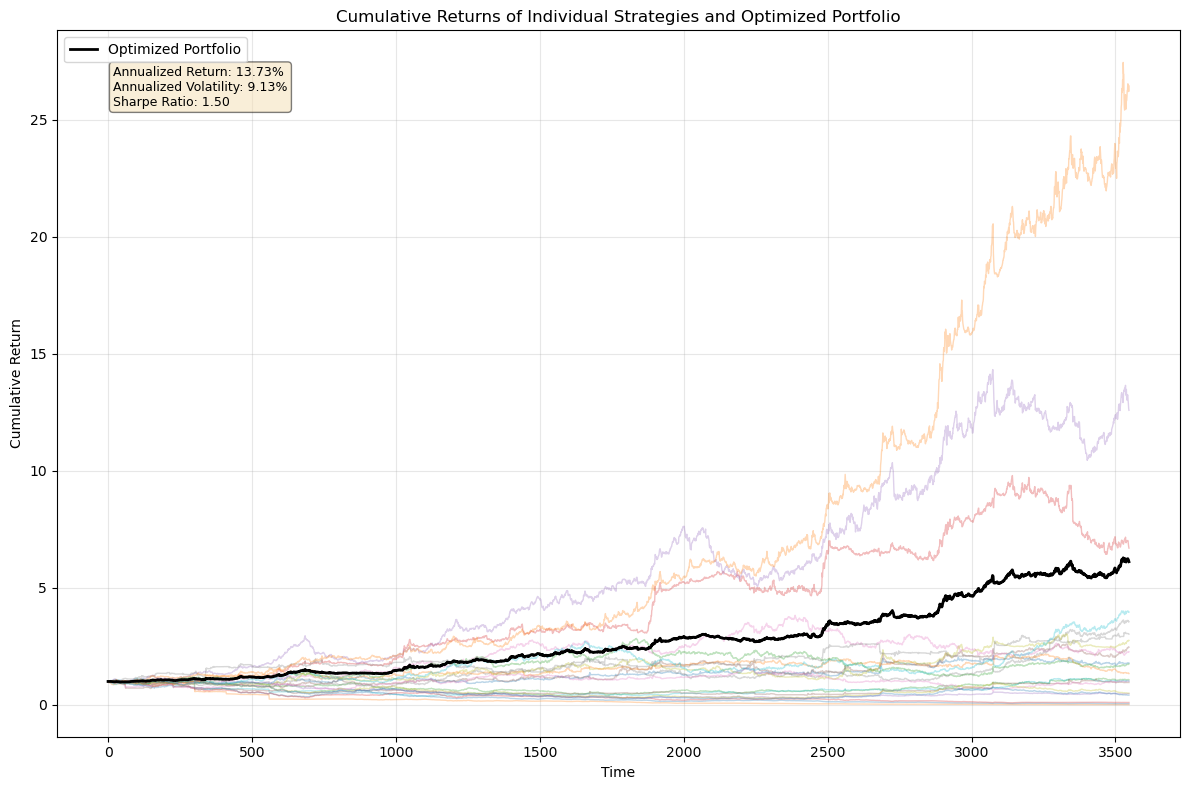

Strategy Allocations:
strat_2: 8.85%
strat_3: 10.00%
strat_4: 10.00%
strat_5: 2.16%
strat_6: 10.00%
strat_7: 2.27%
strat_8: 5.83%
strat_9: 0.26%
strat_12: 10.00%
strat_15: 1.23%
strat_16: 2.87%
strat_17: 10.00%
strat_18: 6.52%
strat_19: 10.00%
strat_21: 10.00%


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming dp1 is your DataFrame with strategy returns
# and optimal_weights is the array of optimal weights we calculated earlier

# Calculate cumulative returns for each strategy
cumulative_returns = (1 + dp1/100).cumprod()

# Calculate the portfolio's cumulative return
portfolio_cumulative_return = np.sum(cumulative_returns * optimal_weights, axis=1)

# Plotting
plt.figure(figsize=(12, 8))

# Plot individual strategy returns
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], alpha=0.3, linewidth=1)

# Plot portfolio return
plt.plot(cumulative_returns.index, portfolio_cumulative_return, 'k', linewidth=2, label='Optimized Portfolio')

plt.title("Cumulative Returns of Individual Strategies and Optimized Portfolio")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

# Add text box with portfolio metrics
annualized_return = (portfolio_cumulative_return.iloc[-1]**(252/len(portfolio_cumulative_return)) - 1) * 100
annualized_volatility = np.std(portfolio_cumulative_return.pct_change()) * np.sqrt(252) * 100
sharpe_ratio = annualized_return / annualized_volatility

textstr = '\n'.join((
    f'Annualized Return: {annualized_return:.2f}%',
    f'Annualized Volatility: {annualized_volatility:.2f}%',
    f'Sharpe Ratio: {sharpe_ratio:.2f}'
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Print strategy allocations
print("Strategy Allocations:")
for strat, weight in zip(dp1.columns, optimal_weights):
    if weight > 0.0001:  # Only print strategies with non-zero allocation
        print(f"{strat}: {weight*100:.2f}%")

In [16]:
dp2 = cryptpandas.read_encrypted(path="./release_3803.crypt", password='0n74wuaJ2wm8A4qC')
dp2 = dp2.fillna(0)
dp2


strat_0   strat_1   strat_2   strat_3   strat_4   strat_5   strat_6  \
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    -1.045104  0.000000  0.000000  0.000000  0.000000  0.139780  1.481773   
2    -0.229267  0.000000  0.000000  0.000000  0.000000  0.109780  0.731916   
3    -0.332475  0.000000 -0.056052  0.000000  0.000000 -0.038044 -0.557418   
4    -0.827446  0.000000 -0.349031  0.000000  0.000000 -0.035166 -1.177777   
...        ...       ...       ...       ...       ...       ...       ...   
3799  0.016162 -1.380859  0.702429 -0.176980  0.422935  0.211449  0.488330   
3800  0.265821 -1.535213 -1.146778 -0.142813  0.384711  1.095813  0.228430   
3801 -0.505313  0.349571 -0.157827 -0.149880 -0.643632  0.695854  0.195377   
3802  0.467539 -0.216723  1.203788 -0.017460  0.524787  0.511419  0.138234   
3803  0.000000 -0.005921  0.050632 -0.065127  0.000000  0.000000  0.000000   

       strat_7   strat_8   strat_9  ...  strat_16  strat_17  strat_18  \
0     0.000000  0.000000  0.000000  ... -1.216100  0.000000  0.000000   
1     0.000000  1.298774  0.000000  ...  1.344721 -0.175514  0.000000   
2     0.000000  1.748748  0.000000  ...  0.681587 -0.235082 -1.271263   
3    -0.246940  0.043789  0.000000  ... -0.403906  0.249474 -0.151417   
4    -0.795178 -1.105112  0.000000  ... -0.813284  0.143559  0.391880   
...        ...       ...       ...  ...       ...       ...       ...   
3799 -0.687317  0.313821  0.738325  ...  0.498843 -0.271786 -0.083375   
3800 -0.296063  1.191847  0.597847  ...  0.068466 -0.330796 -1.271781   
3801  1.268825  0.362774  0.797725  ...  0.252030  0.159433 -0.738728   
3802  0.757911  0.498237  0.670691  ...  0.792731  0.219781 -0.535748   
3803  0.015923  0.000000  0.020357  ...  0.000000 -0.000129  0.000000   

      strat_19  strat_20  strat_21  strat_22  strat_23  strat_24  strat_25  
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1     0.000000  0.000000 -0.827335  0.000000  0.000000  0.000000 -0.961659  
2     0.000000  0.000000 -0.121570  0.000000  0.272799  0.000000  0.296258  
3    -0.253624  0.000000 -1.002791 -0.138613 -2.054721  0.000000 -0.902021  
4    -0.888127  0.000000  0.233682 -0.819131 -2.253448  0.000000  0.407450  
...        ...       ...       ...       ...       ...       ...       ...  
3799 -0.918781 -0.130822 -0.779010  0.312011 -0.505454  0.552299 -0.187483  
3800 -0.258864 -1.087341  0.176759  1.285885 -0.217496  0.046524  0.762595  
3801  1.060196 -0.490976  0.789788  0.251892 -0.489808  0.227510  0.418908  
3802  0.701251 -0.409208  0.876239  0.533422 -0.998400 -0.436387  0.321206  
3803  0.011219  0.000000 -0.002250  0.000000 -0.010150 -0.011371 -0.009909  

[3804 rows x 26 columns]

In [25]:
newDp = cryptpandas.read_encrypted(path="./release_5659.crypt", password='GnkFGu3eeJPoHs4A')
newDp = newDp.fillna(0)

In [27]:
import pandas as pd
import numpy as np

In [29]:
np.isinf(newDp).sum().sum()
cleaned_newDp = newDp.replace([np.inf, -np.inf], np.nan).dropna()
cleaned_newDp

strat_0   strat_1   strat_2   strat_3    strat_4    strat_5   strat_6  \
0     0.000000  0.000000  0.000000  0.000000   0.000000   0.000000  0.000000   
1    -1.045104  0.000000  0.000000  0.000000   0.000000  10.139780  1.481773   
2    -0.229267  0.000000  0.000000  0.000000   0.000000  10.109780  0.731916   
3    -0.332475  0.000000 -0.056052  0.000000   0.000000   9.961956 -0.557418   
4    -0.827446  0.000000 -0.349031  0.000000   0.000000   9.964834 -1.177777   
...        ...       ...       ...       ...        ...        ...       ...   
5655  0.254094  0.442955 -0.060461  0.838382  10.723918  10.051026  0.147526   
5656  0.612618 -1.480208 -0.451930 -1.222001  10.327500  11.042981 -0.146736   
5657  1.799001  1.147554  0.509990 -0.436206   9.183513   6.586296  2.844575   
5658  1.868691 -0.119564 -1.156787 -1.004944   9.368817  10.578181  2.085924   
5659 -0.384157 -0.116036 -0.576337  1.748504  10.732172   9.263186 -0.059460   

       strat_7   strat_8   strat_9  ...  strat_45  strat_46  strat_47  \
0     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1     0.000000  1.298774  0.000000  ...  0.000000  0.193957  0.861984   
2     0.000000  1.748748  0.000000  ...  0.000000 -1.037597  0.468656   
3    -0.246940  0.043789  0.000000  ...  0.000000 -0.271374 -1.492510   
4    -0.795178 -1.105112  0.000000  ...  0.000000  0.514106 -2.172121   
...        ...       ...       ...  ...       ...       ...       ...   
5655  0.081182 -1.756236  0.091044  ... -0.750115 -0.211773  1.308864   
5656  2.377104  3.794209  0.675102  ...  1.394423 -0.516834  0.656598   
5657 -1.322569 -6.474583 -2.328931  ... -1.306245 -0.421796  1.858541   
5658  0.190499  0.666165  0.038375  ... -0.139745  0.862242 -0.656937   
5659 -0.459825 -2.376555  0.061140  ...  0.197293  1.448403  1.419018   

      strat_48  strat_49  strat_50  strat_51  strat_52  strat_53  strat_54  
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1     0.000000  0.000000  0.000000  0.000000  0.133101  0.000000  0.000000  
2     0.000000  0.000000  0.000000  0.000000  2.316091  0.000000  0.000000  
3    -2.476142  0.000000  0.000000  0.000000 -1.183096  0.000000  0.000000  
4    -1.399749  0.000000  0.000000  0.000000 -1.410322  0.000000 -0.008361  
...        ...       ...       ...       ...       ...       ...       ...  
5655  0.365193 -0.432370 -1.244266  0.402641  0.418369 -1.038178 -0.468519  
5656  0.860898  0.953611 -1.523094  0.229312  0.356511  2.633728  1.507019  
5657 -0.209892 -0.579409 -3.923016 -0.303031 -0.094005 -1.086061 -1.912292  
5658 -0.213814  0.237738 -2.060764 -0.225284 -0.216959  2.614267  0.364891  
5659 -0.229917  0.255303 -0.767109  0.828985  0.235181 -0.987371 -0.105951  

[5657 rows x 55 columns]


Cleaned Data:
    strat_0  strat_1   strat_2  strat_3  strat_4    strat_5   strat_6  \
0  0.000000      0.0  0.000000      0.0      0.0   0.000000  0.000000   
1 -1.045104      0.0  0.000000      0.0      0.0  10.139780  1.481773   
2 -0.229267      0.0  0.000000      0.0      0.0  10.109780  0.731916   
3 -0.332475      0.0 -0.056052      0.0      0.0   9.961956 -0.557418   
4 -0.827446      0.0 -0.349031      0.0      0.0   9.964834 -1.177777   

    strat_7   strat_8  strat_9  ...  strat_45  strat_46  strat_47  strat_48  \
0  0.000000  0.000000      0.0  ...       0.0  0.000000  0.000000  0.000000   
1  0.000000  1.298774      0.0  ...       0.0  0.193957  0.861984  0.000000   
2  0.000000  1.748748      0.0  ...       0.0 -1.037597  0.468656  0.000000   
3 -0.246940  0.043789      0.0  ...       0.0 -0.271374 -1.492510 -2.476142   
4 -0.795178 -1.105112      0.0  ...       0.0  0.514106 -2.172121 -1.399749   

   strat_49  strat_50  strat_51  strat_52  strat_53  strat_54  
0      

C:\Users\Thani\AppData\Local\Temp\ipykernel_25828\3531761193.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


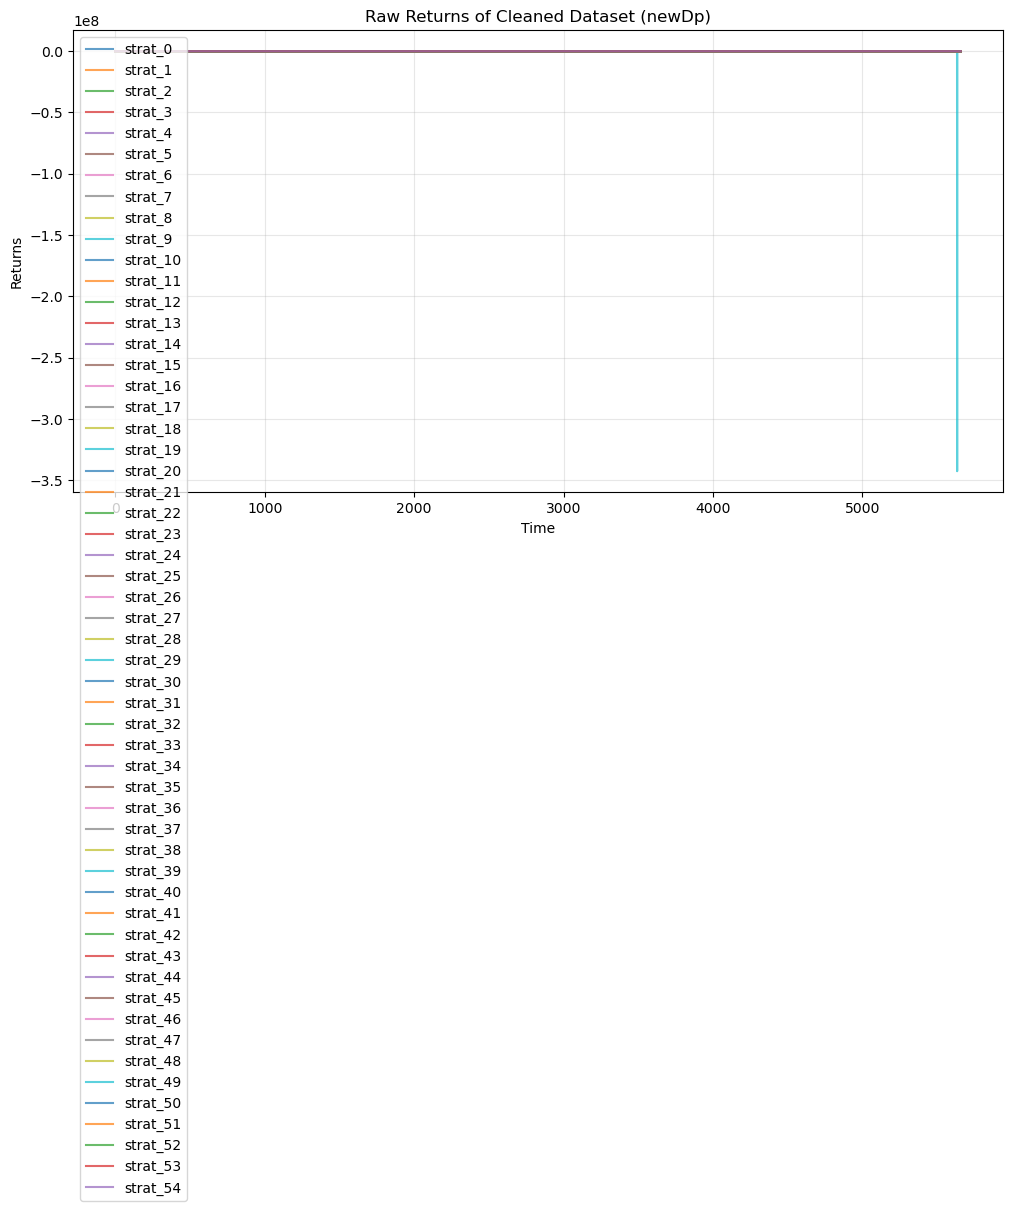

In [31]:
print("\nCleaned Data:")
print(cleaned_newDp.head())

# Step 3: Plot the Raw Returns
plt.figure(figsize=(12, 6))
plt.plot(cleaned_newDp.index, cleaned_newDp, alpha=0.7)
plt.title("Raw Returns of Cleaned Dataset (newDp)")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend(cleaned_newDp.columns, loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Assuming `cleaned_newDp` is already defined and cleaned

# Compute z-scores for numeric columns
z_scores = cleaned_newDp.apply(zscore, axis=0)

# Detect outliers: absolute z-score > 3
outliers = (np.abs(z_scores) > 3)

# Replace outliers with the previous value in the column
for col in cleaned_newDp.columns:
    if cleaned_newDp[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
        # Locate outliers in the column
        outlier_indices = outliers[col]
        # Replace outliers with the previous value (shifted by 1 row)
        cleaned_newDp.loc[outlier_indices, col] = cleaned_newDp[col].shift(1)[outlier_indices]

# Final cleaned dataset
cleaned_newDp.fillna(method='bfill', inplace=True)  # Handle any remaining NaNs by backfilling


C:\Users\Thani\AppData\Local\Temp\ipykernel_25828\4041365103.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_newDp.fillna(method='bfill', inplace=True)  # Handle any remaining NaNs by backfilling


C:\Users\Thani\AppData\Local\Temp\ipykernel_25828\3716280246.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


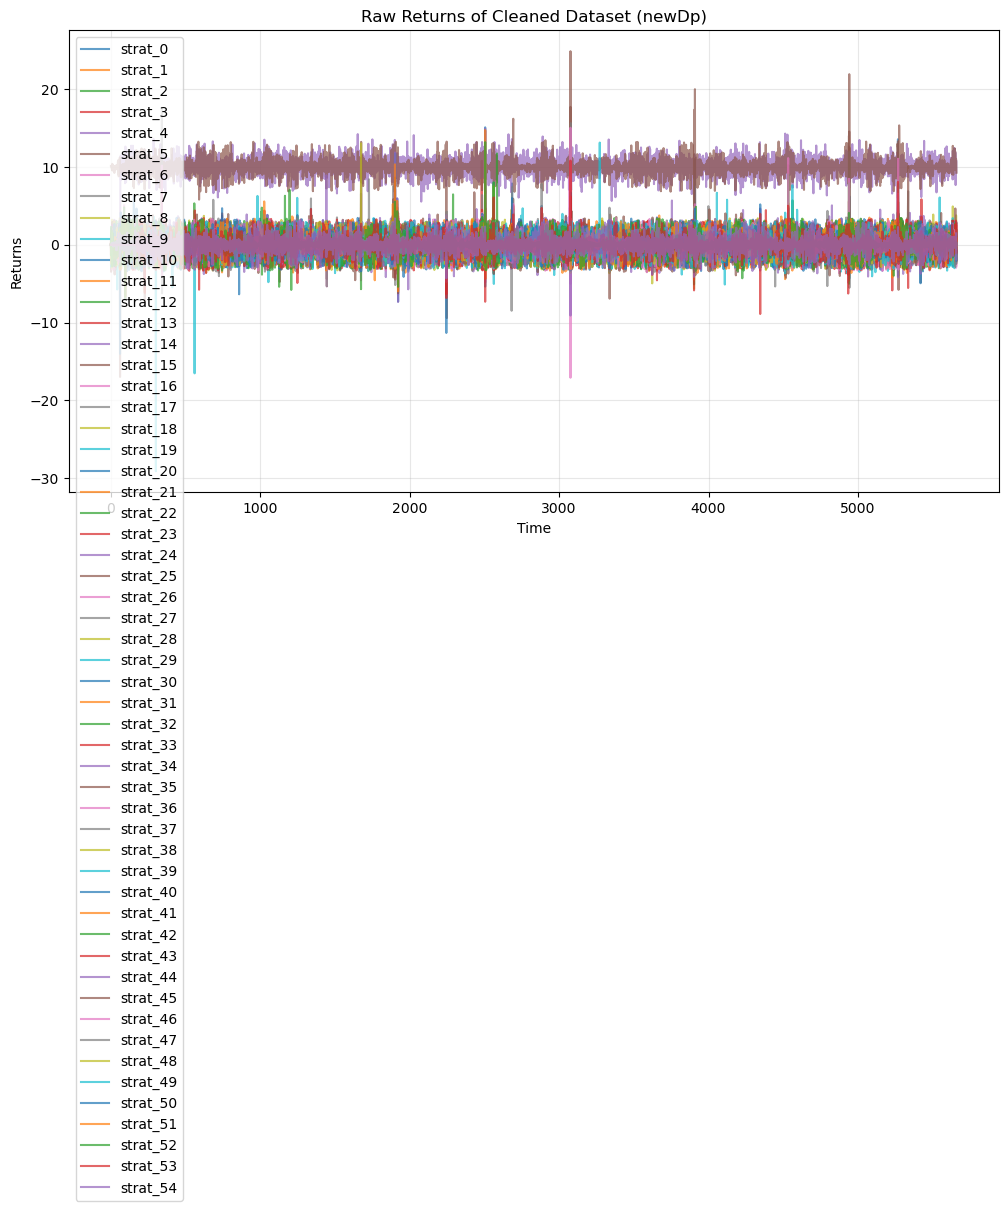

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(cleaned_newDp.index, cleaned_newDp, alpha=0.7)
plt.title("Raw Returns of Cleaned Dataset (newDp)")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend(cleaned_newDp.columns, loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

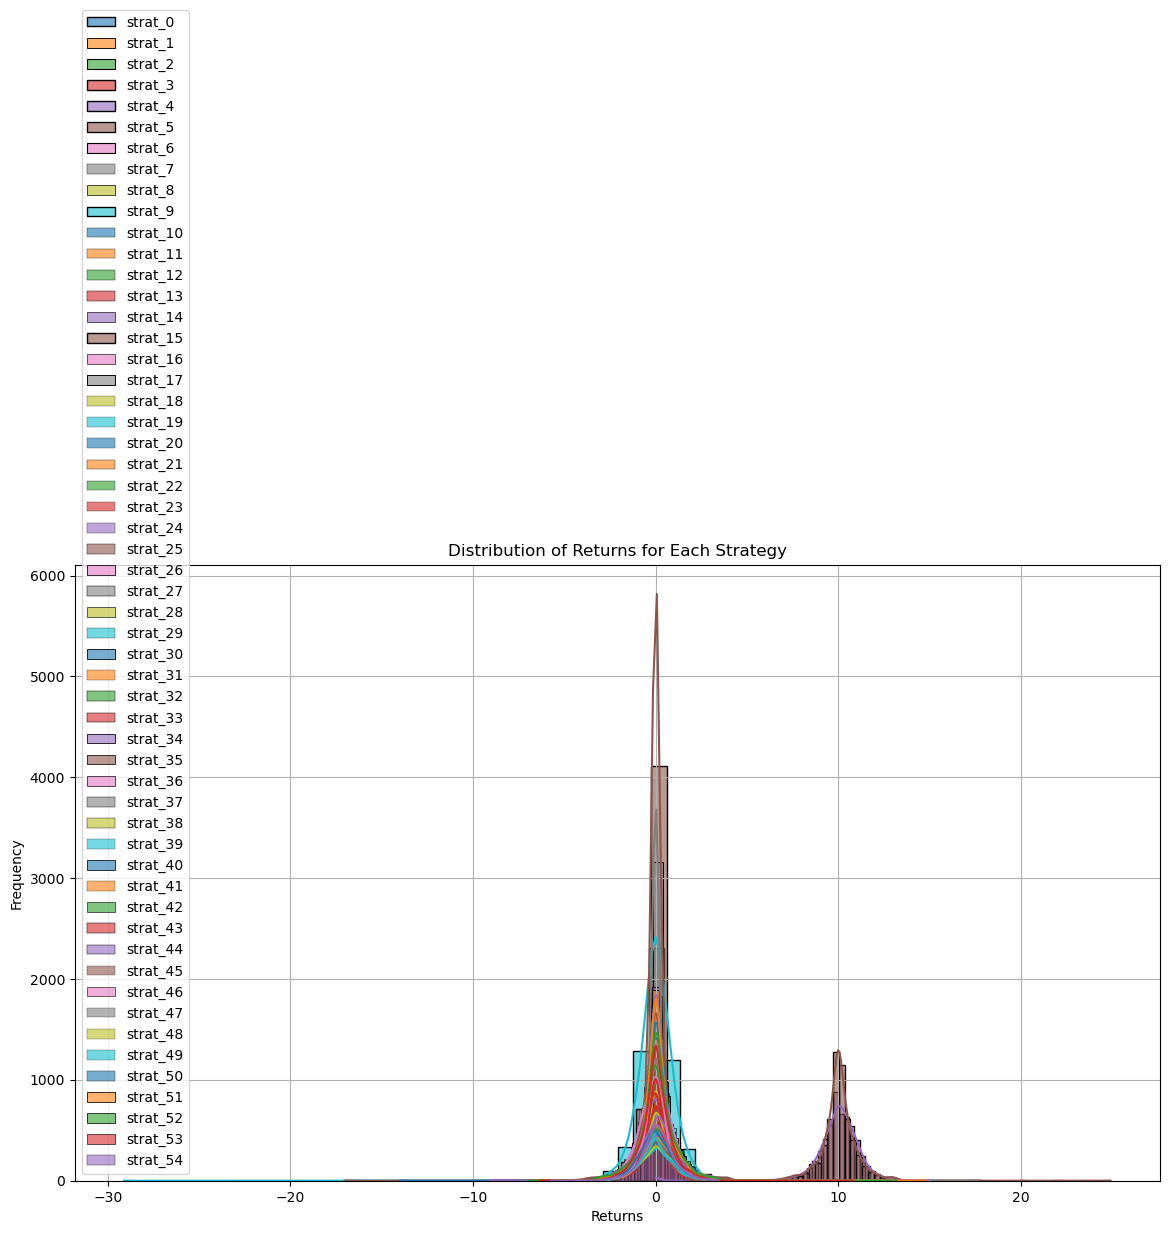

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(14, 8))

# Iterate over each column (strategy) in the cleaned DataFrame
for column in cleaned_newDp.columns:
    sns.histplot(
        cleaned_newDp[column],
        kde=True,  # Add Kernel Density Estimate
        label=column,
        bins=50,   # Number of bins for histogram
        alpha=0.6, # Transparency for overlap
    )

# Add labels, legend, and title
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Returns for Each Strategy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


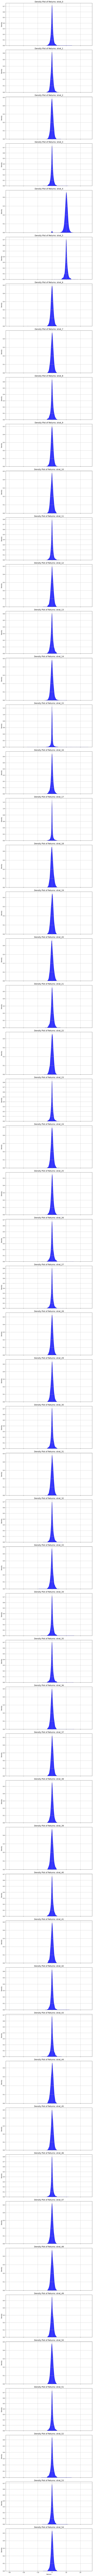

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot grid: one plot per strategy
num_strategies = cleaned_newDp.shape[1]
fig, axes = plt.subplots(num_strategies, 1, figsize=(10, 5 * num_strategies), sharex=True)

# Iterate through each strategy to plot its density
for i, column in enumerate(cleaned_newDp.columns):
    sns.kdeplot(
        data=cleaned_newDp[column],
        ax=axes[i],
        fill=True,  # Filled density plot
        color='blue',  # Customize color as needed
        alpha=0.8
    )
    axes[i].set_title(f"Density Plot of Returns: {column}", fontsize=14)
    axes[i].set_xlabel('Returns')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [ ]:
# Assuming cleaned_newDp is your DataFrame with returns

# Remove strat_4 and strat_5
cleaned_newDp = cleaned_newDp.drop(columns=['strat_4', 'strat_5'])

# Display the cleaned DataFrame after removal
print("DataFrame after removing strat_4 and strat_5:")
print(cleaned_newDp.head())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming cleaned_newDp is your DataFrame with strategy returns
# For demonstration, let's create a sample cleaned_newDp DataFrame
# cleaned_newDp = pd.read_csv('path_to_cleaned_newDp.csv')

# Step 1: Calculate cumulative returns for strat_1
cumulative_returns_strat_1 = (1 + cleaned_newDp['strat_0']/100).cumprod()

# Step 2: Plotting the cumulative returns for strat_1
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_strat_1.index, cumulative_returns_strat_1, color='blue', linewidth=2, label='Cumulative Returns of Strat 1')
plt.title("Cumulative Returns of Strat 1")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



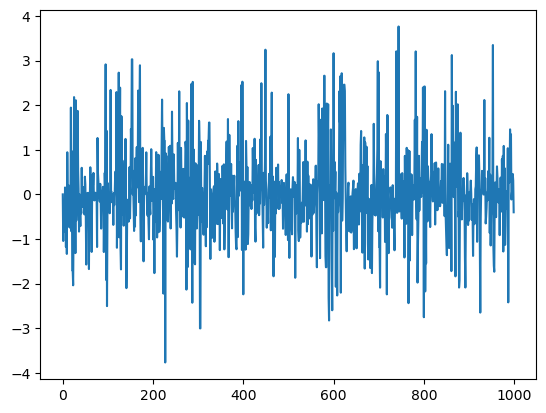

In [54]:
plt.plot(cleaned_newDp['strat_0'].index[:1000], cleaned_newDp['strat_0'].iloc[:1000])


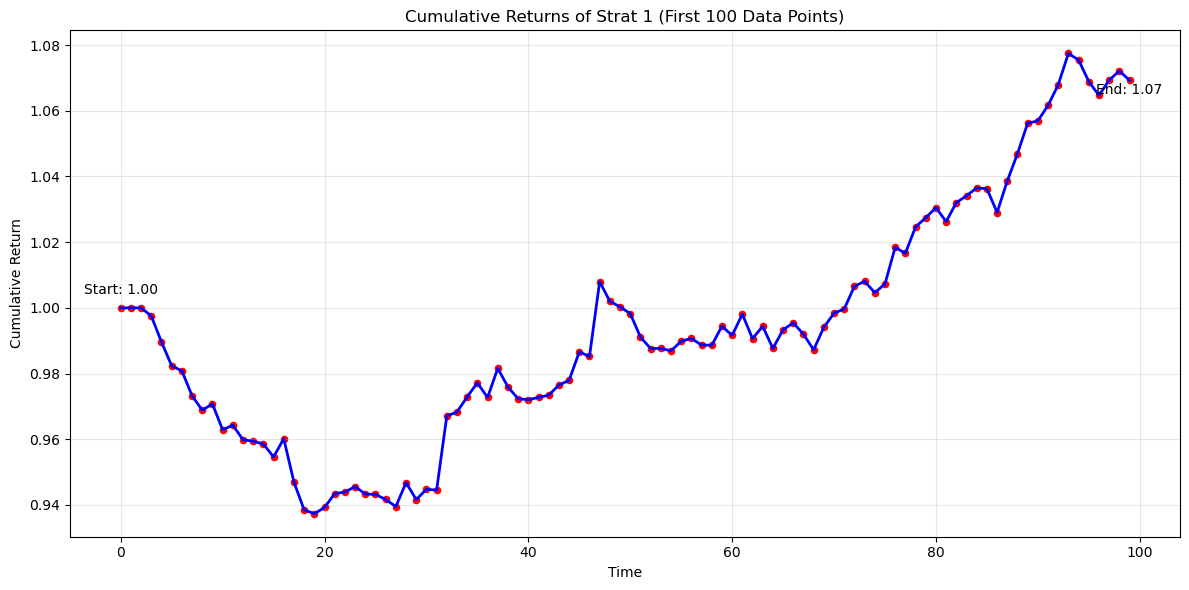

First 10 cumulative returns:
0    1.000000
1    1.000000
2    1.000000
3    0.997531
4    0.989598
5    0.982348
6    0.980808
7    0.973230
8    0.968824
9    0.970744
Name: strat_7, dtype: float64

Maximum cumulative return in first 100 points:
Index: 93, Value: 1.08

Minimum cumulative return after the maximum:
Index: 145, Value: 0.98


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming cleaned_newDp is your DataFrame with returns

# Calculate cumulative returns for strat_1
cumulative_returns_strat_1 = (1 + cleaned_newDp['strat_7']/100).cumprod()

# Plot cumulative returns for the first 100 data points
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_strat_1.index[:100], cumulative_returns_strat_1.iloc[:100], color='blue', linewidth=2)
plt.title("Cumulative Returns of Strat 1 (First 100 Data Points)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(alpha=0.3)

# Add markers to easily identify specific points
plt.scatter(cumulative_returns_strat_1.index[:100], cumulative_returns_strat_1.iloc[:100], color='red', s=20)

# Annotate the first and last point
first_point = cumulative_returns_strat_1.iloc[0]
last_point = cumulative_returns_strat_1.iloc[99]
plt.annotate(f'Start: {first_point:.2f}', (cumulative_returns_strat_1.index[0], first_point), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f'End: {last_point:.2f}', (cumulative_returns_strat_1.index[99], last_point), textcoords="offset points", xytext=(0,-10), ha='center')

plt.tight_layout()
plt.show()

# Print the first few values
print("First 10 cumulative returns:")
print(cumulative_returns_strat_1.head(10))

# Find the index of the maximum value in the first 100 points
max_index = cumulative_returns_strat_1.iloc[:100].idxmax()
max_value = cumulative_returns_strat_1.loc[max_index]

print(f"\nMaximum cumulative return in first 100 points:")
print(f"Index: {max_index}, Value: {max_value:.2f}")

# Find the index of the minimum value after the maximum
min_index_after_max = cumulative_returns_strat_1.loc[max_index:].idxmin()
min_value_after_max = cumulative_returns_strat_1.loc[min_index_after_max]

print(f"\nMinimum cumulative return after the maximum:")
print(f"Index: {min_index_after_max}, Value: {min_value_after_max:.2f}")

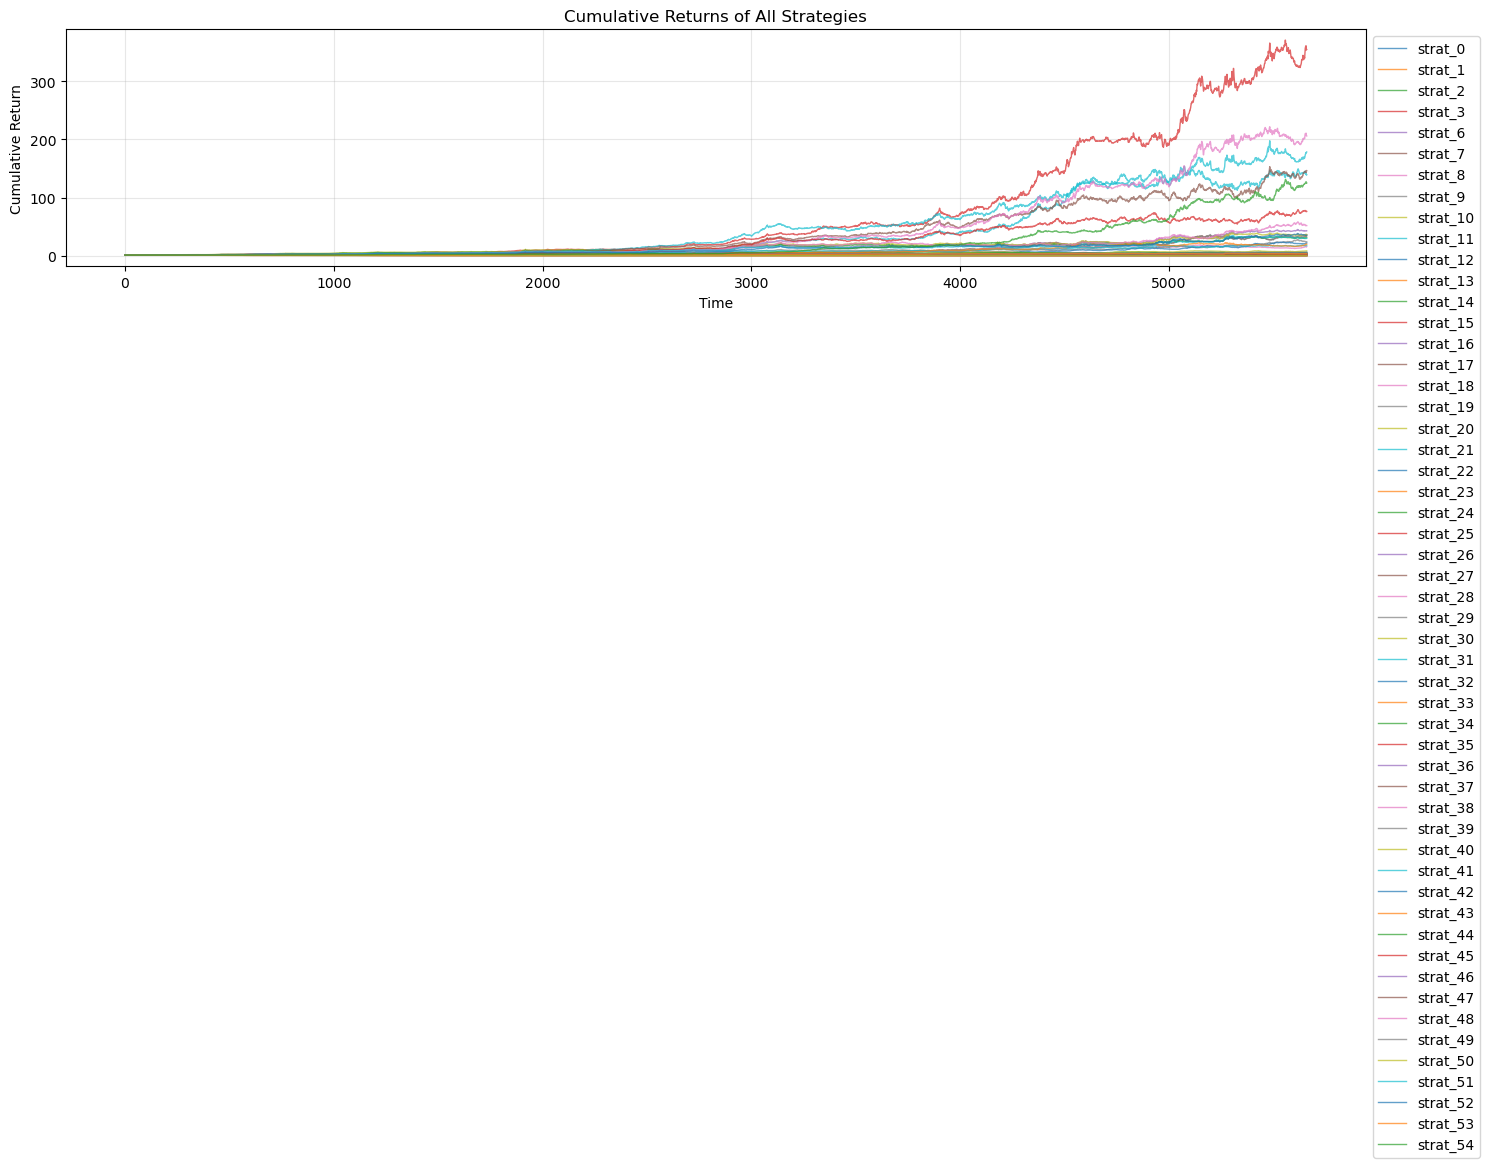

Summary Statistics of Cumulative Returns at the End:
count     53.000000
mean      31.778073
std       65.391365
min        0.008699
25%        0.696332
50%        3.930013
75%       30.897145
max      354.777350
Name: 5659, dtype: float64

Best performing strategy: strat_25
Final cumulative return: 354.78

Worst performing strategy: strat_10
Final cumulative return: 0.01


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming cleaned_newDp is your DataFrame with returns

# Calculate cumulative returns for all strategies
cumulative_returns = (1 + cleaned_newDp/100).cumprod()

# Plot cumulative returns for all strategies
plt.figure(figsize=(15, 8))

for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column, linewidth=1, alpha=0.7)

plt.title("Cumulative Returns of All Strategies")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.3)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print("Summary Statistics of Cumulative Returns at the End:")
print(cumulative_returns.iloc[-1].describe())

# Identify best and worst performing strategies
best_strategy = cumulative_returns.iloc[-1].idxmax()
worst_strategy = cumulative_returns.iloc[-1].idxmin()

print(f"\nBest performing strategy: {best_strategy}")
print(f"Final cumulative return: {cumulative_returns.iloc[-1][best_strategy]:.2f}")

print(f"\nWorst performing strategy: {worst_strategy}")
print(f"Final cumulative return: {cumulative_returns.iloc[-1][worst_strategy]:.2f}")

Adjusted Strategy Allocations:
strat_2: 10.08%
strat_3: 11.39%
strat_6: 11.39%
strat_7: 2.58%
strat_8: 6.64%
strat_9: 0.30%
strat_12: 11.39%
strat_15: 1.40%
strat_16: 3.27%
strat_17: 11.39%
strat_18: 7.42%
strat_19: 11.39%
strat_21: 11.39%


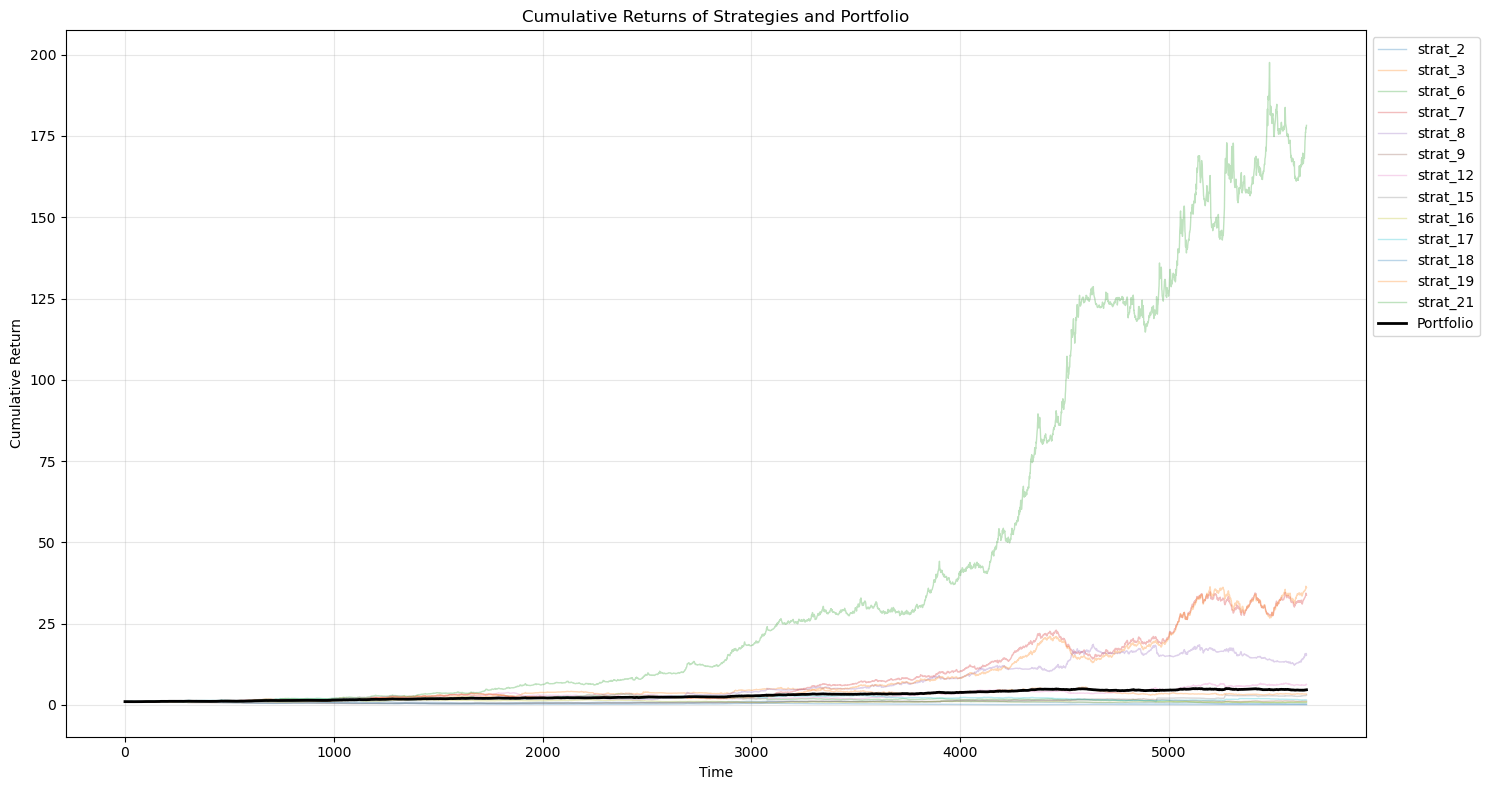


Portfolio Performance Metrics:
Total Return: 364.25%
Annualized Return: 7.08%
Annualized Volatility: 5.85%
Sharpe Ratio: 7.07


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Original allocations
original_allocations = {
    'strat_2': 0.0885, 'strat_3': 0.1000, 'strat_6': 0.1000, 'strat_7': 0.0227,
    'strat_8': 0.0583, 'strat_9': 0.0026, 'strat_12': 0.1000, 'strat_15': 0.0123,
    'strat_16': 0.0287, 'strat_17': 0.1000, 'strat_18': 0.0652, 'strat_19': 0.1000,
    'strat_21': 0.1000
}

# Calculate the total weight to redistribute
total_weight = sum(original_allocations.values())
weight_to_redistribute = 1 - total_weight

# Adjust weights
adjusted_allocations = {strat: weight * (1 + weight_to_redistribute / total_weight) 
                        for strat, weight in original_allocations.items()}

# Normalize to ensure weights sum to 1
total_adjusted_weight = sum(adjusted_allocations.values())
adjusted_allocations = {strat: weight / total_adjusted_weight for strat, weight in adjusted_allocations.items()}

# Print adjusted allocations
print("Adjusted Strategy Allocations:")
for strat, weight in adjusted_allocations.items():
    print(f"{strat}: {weight*100:.2f}%")

# Assuming cleaned_newDp is your DataFrame with returns
# Calculate cumulative returns for all strategies
cumulative_returns = (1 + cleaned_newDp/100).cumprod()

# Calculate portfolio returns
portfolio_returns = pd.Series(0, index=cleaned_newDp.index)
for strat, weight in adjusted_allocations.items():
    portfolio_returns += cleaned_newDp[strat] * weight

# Calculate cumulative portfolio returns
cumulative_portfolio_returns = (1 + portfolio_returns/100).cumprod()

# Plotting
plt.figure(figsize=(15, 8))

# Plot individual strategy returns
for column in cumulative_returns.columns:
    if column in adjusted_allocations:
        plt.plot(cumulative_returns.index, cumulative_returns[column], label=column, linewidth=1, alpha=0.3)

# Plot portfolio returns
plt.plot(cumulative_returns.index, cumulative_portfolio_returns, label='Portfolio', linewidth=2, color='black')

plt.title("Cumulative Returns of Strategies and Portfolio")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.3)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print portfolio performance metrics
total_return = (cumulative_portfolio_returns.iloc[-1] - 1) * 100
annualized_return = ((1 + total_return/100) ** (252/len(cumulative_portfolio_returns)) - 1) * 100
annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)
risk_free_rate = 0.05  # 5% risk-free rate

sharpe_ratio = annualized_return - risk_free_rate / annualized_volatility

print(f"\nPortfolio Performance Metrics:")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

New Optimized Strategy Allocations:
strat_0: 3.79%
strat_8: 1.20%
strat_12: 2.24%
strat_15: 0.82%
strat_21: 10.00%
strat_22: 4.00%
strat_25: 2.82%
strat_29: 2.69%
strat_31: 5.13%
strat_32: 7.03%
strat_37: 5.91%
strat_38: 4.49%
strat_40: 10.00%
strat_42: 1.14%
strat_45: 0.84%
strat_48: 0.26%
strat_52: 6.89%
strat_54: 9.68%
strat_64: 1.59%
strat_67: 3.94%
strat_71: 9.71%
strat_73: 4.84%
strat_77: 0.98%


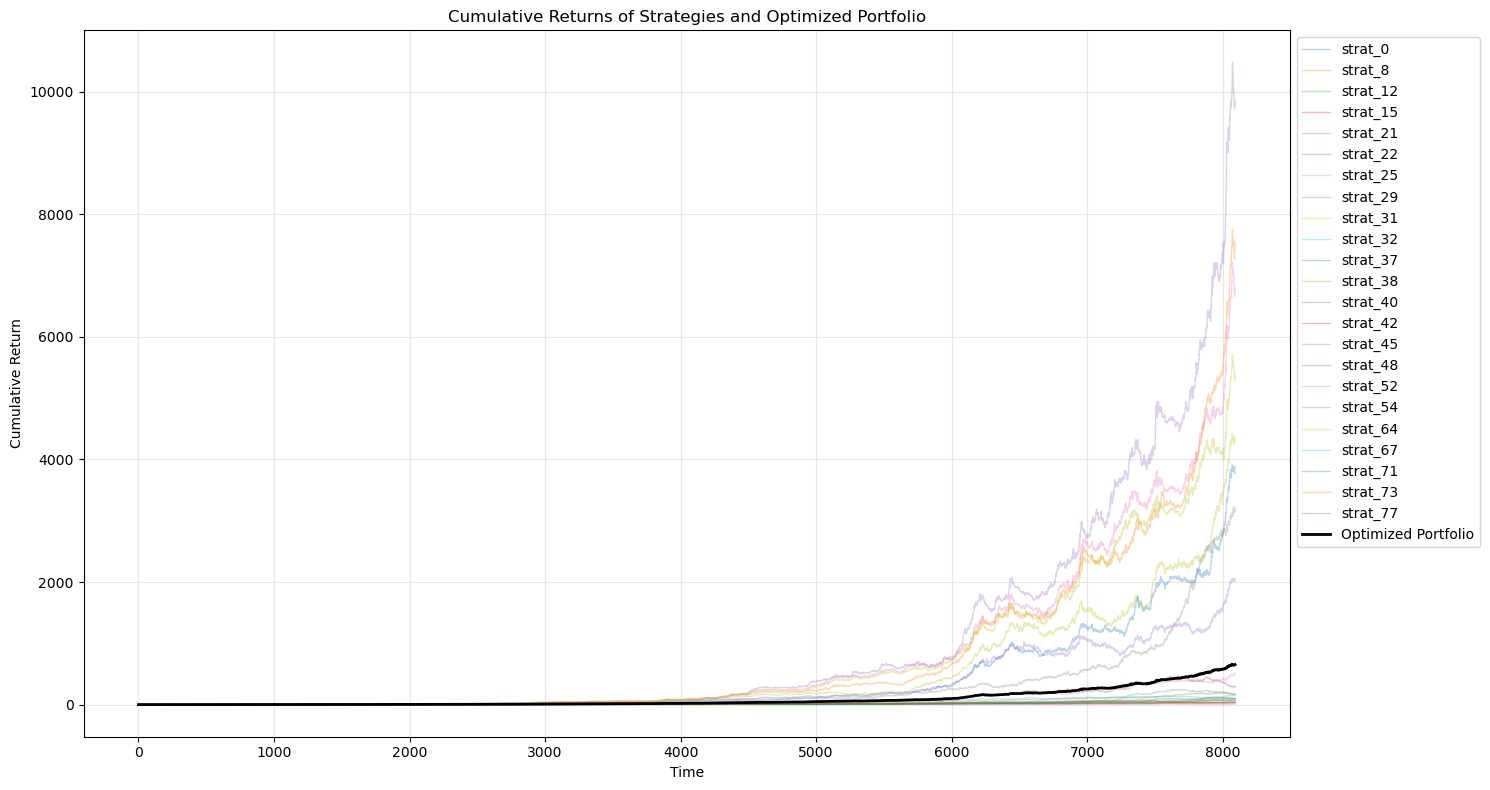


Optimized Portfolio Performance Metrics:
Total Return: 65179.39%
Annualized Return: 22.37%
Annualized Volatility: 5.32%
Sharpe Ratio: 3.27


In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming latestDp is your DataFrame with cleaned returns data

# Step 1: Mean-Variance Optimization

# Calculate expected returns and covariance
expected_returns = latestDp.mean()
cov_matrix = latestDp.cov()

# Define the objective function (negative Sharpe ratio)
def objective(weights):
    portfolio_return = np.sum(expected_returns * weights) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized volatility
    return -(portfolio_return - 0.05 * 100) / portfolio_volatility  # Negative Sharpe ratio with 5% risk-free rate

# Define constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 0.1) for asset in range(len(latestDp.columns)))  # Each weight between 0 and 10%

# Perform optimization
num_assets = len(latestDp.columns)
initial_weights = np.array([1/num_assets] * num_assets)
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Get optimized weights
optimized_weights = result.x

# Step 2: Get new allocations
new_allocations = dict(zip(latestDp.columns, optimized_weights))

print("New Optimized Strategy Allocations:")
for strat, weight in new_allocations.items():
    if weight > 0.0001:  # Only print non-zero allocations
        print(f"{strat}: {weight*100:.2f}%")

# Step 3: Backtest the new allocations

# Calculate cumulative returns for all strategies
cumulative_returns = (1 + latestDp/100).cumprod()

# Calculate portfolio returns
portfolio_returns = pd.Series(0, index=latestDp.index)
for strat, weight in new_allocations.items():
    portfolio_returns += latestDp[strat] * weight

# Calculate cumulative portfolio returns
cumulative_portfolio_returns = (1 + portfolio_returns/100).cumprod()

# Plotting
plt.figure(figsize=(15, 8))

# Plot individual strategy returns
for column in cumulative_returns.columns:
    if new_allocations[column] > 0.0001:  # Only plot strategies with non-zero allocation
        plt.plot(cumulative_returns.index, cumulative_returns[column], label=column, linewidth=1, alpha=0.3)

# Plot portfolio returns
plt.plot(cumulative_returns.index, cumulative_portfolio_returns, label='Optimized Portfolio', linewidth=2, color='black')

plt.title("Cumulative Returns of Strategies and Optimized Portfolio")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.3)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print portfolio performance metrics
total_return = (cumulative_portfolio_returns.iloc[-1] - 1) * 100
annualized_return = ((1 + total_return/100) ** (252/len(cumulative_portfolio_returns)) - 1) * 100
annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)

# Calculate Sharpe Ratio with 5% risk-free rate
risk_free_rate = 0.05  # 5% risk-free rate
sharpe_ratio = (annualized_return - risk_free_rate * 100) / annualized_volatility

print(f"\nOptimized Portfolio Performance Metrics:")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

In [134]:
latestDp = cryptpandas.read_encrypted(path="./release_8091.crypt", password='cSh9mVS1ejq39Tu8')
latestDp


strat_0   strat_1   strat_2   strat_3    strat_4    strat_5   strat_6  \
0          NaN       NaN       NaN       NaN        NaN        NaN       NaN   
1    -1.045104       NaN       NaN       NaN        NaN  10.139780  1.481773   
2    -0.229267       NaN       NaN       NaN        NaN  10.109780  0.731916   
3    -0.332475       NaN -0.056052       NaN        NaN   9.961956 -0.557418   
4    -0.827446       NaN -0.349031       NaN        NaN   9.964834 -1.177777   
...        ...       ...       ...       ...        ...        ...       ...   
8087  0.332568  0.017935 -0.482419 -0.039005   9.743428   9.054211  0.267187   
8088 -0.303762 -0.549982  0.949779 -0.114858   9.809708   9.584838 -1.107471   
8089 -1.087419 -0.959819  0.986963  0.783428  11.911658  11.325698 -0.025486   
8090  0.339084 -0.283152  0.922165  0.898213  11.263171   9.290094 -1.045970   
8091  0.022385 -0.575414  0.670732  0.973323  10.585298  10.321675  0.188157   

       strat_7   strat_8   strat_9  ...  strat_83  strat_84  strat_85  \
0          NaN       NaN       NaN  ...       NaN       NaN       NaN   
1          NaN  1.298774       NaN  ...  0.747541       NaN       NaN   
2          NaN  1.748748       NaN  ...  0.175328  0.495794  0.349800   
3    -0.246940  0.043789       NaN  ... -1.682984  2.016208  0.116407   
4    -0.795178 -1.105112       NaN  ... -1.167333  0.216202 -0.427551   
...        ...       ...       ...  ...       ...       ...       ...   
8087  0.883425 -1.046781 -0.336520  ...  0.036554  0.853884  1.193040   
8088 -0.732817  0.012903 -0.112253  ... -0.334417  1.301673 -0.801951   
8089 -1.572171  1.367781  0.521088  ...  0.027840  1.292017 -1.550612   
8090  0.926930 -1.008909  0.674864  ...  0.813438  0.505864  1.320077   
8091 -0.093730  0.542283  0.378125  ...  1.343618  0.714877 -0.184824   

      strat_86  strat_87  strat_88  strat_89  strat_90  strat_91  strat_92  
0          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1          NaN -1.403530 -0.582978       NaN       NaN       NaN       NaN  
2          NaN  2.329688 -0.328429       NaN       NaN       NaN       NaN  
3          NaN -1.942029 -0.042355       NaN       NaN       NaN -0.133318  
4          NaN  0.314626 -0.066084       NaN       NaN       NaN -1.354008  
...        ...       ...       ...       ...       ...       ...       ...  
8087  0.192195 -0.008264 -0.427917  0.248824 -0.576577 -0.115050 -0.620551  
8088  0.076525  0.957654 -0.521794 -0.202394  0.322669  0.155223  0.454326  
8089  1.126592  1.505480  0.286166  0.287163  1.265132  1.424136  0.417539  
8090  0.607475  0.182315 -0.313343  0.364552  0.703347  0.235528  0.561053  
8091  1.126180  0.977847  0.246221  0.805772  0.363243  1.014806 -0.519055  

[8092 rows x 93 columns]

In [136]:
latestDp = latestDp.fillna(0)
latestDp


strat_0   strat_1   strat_2   strat_3    strat_4    strat_5   strat_6  \
0     0.000000  0.000000  0.000000  0.000000   0.000000   0.000000  0.000000   
1    -1.045104  0.000000  0.000000  0.000000   0.000000  10.139780  1.481773   
2    -0.229267  0.000000  0.000000  0.000000   0.000000  10.109780  0.731916   
3    -0.332475  0.000000 -0.056052  0.000000   0.000000   9.961956 -0.557418   
4    -0.827446  0.000000 -0.349031  0.000000   0.000000   9.964834 -1.177777   
...        ...       ...       ...       ...        ...        ...       ...   
8087  0.332568  0.017935 -0.482419 -0.039005   9.743428   9.054211  0.267187   
8088 -0.303762 -0.549982  0.949779 -0.114858   9.809708   9.584838 -1.107471   
8089 -1.087419 -0.959819  0.986963  0.783428  11.911658  11.325698 -0.025486   
8090  0.339084 -0.283152  0.922165  0.898213  11.263171   9.290094 -1.045970   
8091  0.022385 -0.575414  0.670732  0.973323  10.585298  10.321675  0.188157   

       strat_7   strat_8   strat_9  ...  strat_83  strat_84  strat_85  \
0     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1     0.000000  1.298774  0.000000  ...  0.747541  0.000000  0.000000   
2     0.000000  1.748748  0.000000  ...  0.175328  0.495794  0.349800   
3    -0.246940  0.043789  0.000000  ... -1.682984  2.016208  0.116407   
4    -0.795178 -1.105112  0.000000  ... -1.167333  0.216202 -0.427551   
...        ...       ...       ...  ...       ...       ...       ...   
8087  0.883425 -1.046781 -0.336520  ...  0.036554  0.853884  1.193040   
8088 -0.732817  0.012903 -0.112253  ... -0.334417  1.301673 -0.801951   
8089 -1.572171  1.367781  0.521088  ...  0.027840  1.292017 -1.550612   
8090  0.926930 -1.008909  0.674864  ...  0.813438  0.505864  1.320077   
8091 -0.093730  0.542283  0.378125  ...  1.343618  0.714877 -0.184824   

      strat_86  strat_87  strat_88  strat_89  strat_90  strat_91  strat_92  
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1     0.000000 -1.403530 -0.582978  0.000000  0.000000  0.000000  0.000000  
2     0.000000  2.329688 -0.328429  0.000000  0.000000  0.000000  0.000000  
3     0.000000 -1.942029 -0.042355  0.000000  0.000000  0.000000 -0.133318  
4     0.000000  0.314626 -0.066084  0.000000  0.000000  0.000000 -1.354008  
...        ...       ...       ...       ...       ...       ...       ...  
8087  0.192195 -0.008264 -0.427917  0.248824 -0.576577 -0.115050 -0.620551  
8088  0.076525  0.957654 -0.521794 -0.202394  0.322669  0.155223  0.454326  
8089  1.126592  1.505480  0.286166  0.287163  1.265132  1.424136  0.417539  
8090  0.607475  0.182315 -0.313343  0.364552  0.703347  0.235528  0.561053  
8091  1.126180  0.977847  0.246221  0.805772  0.363243  1.014806 -0.519055  

[8092 rows x 93 columns]

In [138]:

np.isinf(latestDp).sum().sum()
latestDp[latestDp == np.inf] = 0 

In [140]:
np.isinf(latestDp).sum().sum()
latestDp[latestDp == -np.inf] = 0 


In [239]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming latestDp is your DataFrame with the latest returns data
# # If it's not already loaded, uncomment and modify the following line:
# # latestDp = pd.read_csv('path_to_your_latestDp_file.csv')

# # Set up the plot style
# plt.style.use('seaborn')
# sns.set_palette("husl")

# # Calculate the number of rows and columns for subplots
# n_strats = len(latestDp.columns)
# n_cols = 5  # You can adjust this number to change the layout
# n_rows = (n_strats - 1) // n_cols + 1

# # Create a large figure
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
# fig.suptitle("Distribution of Returns for Each Strategy", fontsize=16)

# # Flatten the axes array for easier indexing
# axes = axes.flatten()

# # Plot distribution for each strategy
# for i, column in enumerate(latestDp.columns):
#     ax = axes[i]
#     sns.histplot(latestDp[column], kde=True, ax=ax)
#     ax.set_title(f'Strategy {column}')
#     ax.set_xlabel('Returns')
#     ax.set_ylabel('Frequency')
    
#     # Add mean and std as text
#     mean = latestDp[column].mean()
#     std = latestDp[column].std()
#     ax.text(0.05, 0.95, f'Mean: {mean:.2f}\nStd: {std:.2f}', 
#             transform=ax.transAxes, verticalalignment='top')

# # Remove any unused subplots
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

# # Print summary statistics
# print(latestDp.describe())

Shifted strat_4 and strat_5 by -10


C:\Users\Thani\AppData\Local\Temp\ipykernel_25828\2643500434.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  latestDp.fillna(method='bfill', inplace=True)  # Handle any remaining NaNs by backfilling



Number of outliers replaced in each column:
strat_0     340
strat_1     104
strat_2      46
strat_3     301
strat_4     130
           ... 
strat_88    337
strat_89    169
strat_90     57
strat_91    169
strat_92     54
Length: 93, dtype: int64

After shifting and cleaning:
           strat_0      strat_1      strat_2      strat_3      strat_4  \
count  8092.000000  8092.000000  8092.000000  8092.000000  8092.000000   
mean      0.046903    -0.087643    -0.006667     0.049433    -0.012139   
std       0.728413     0.776980     0.811875     0.712310     1.218065   
min      -6.451317    -3.255935    -2.697235    -7.579964   -10.000000   
25%      -0.326651    -0.579823    -0.535582    -0.337010    -0.499132   
50%       0.026998    -0.068291    -0.012049     0.014600     0.047135   
75%       0.379893     0.387345     0.518906     0.411501     0.609542   
max      13.571672     7.365662     5.881561    10.929815     2.575431   

           strat_5      strat_6      strat_7      strat_8

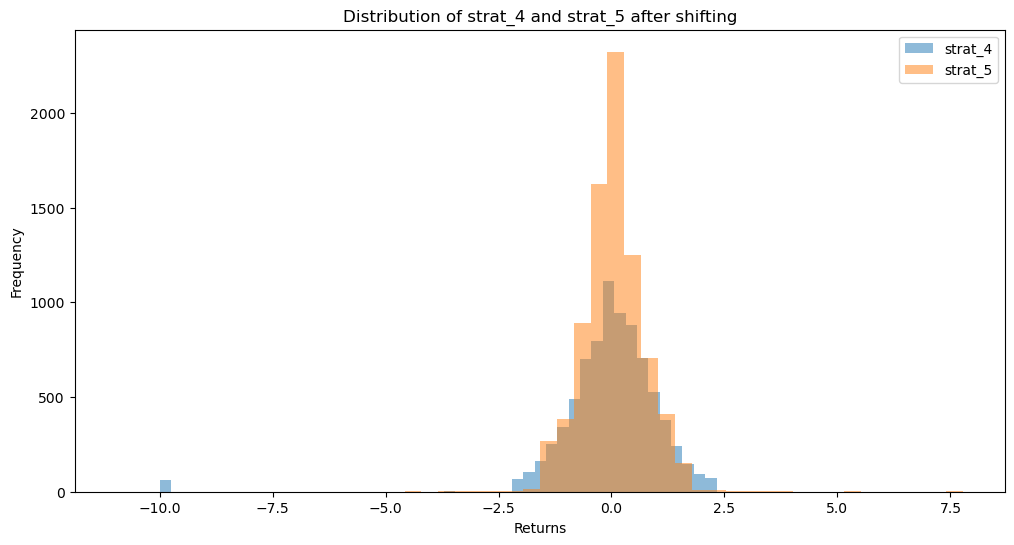

In [148]:
import numpy as np
import pandas as pd

# Assuming `latestDp` is already defined

# Shift strat_4 and strat_5 by minus 10
if 'strat_4' in latestDp.columns:
    latestDp['strat_4'] = latestDp['strat_4'] - 10
if 'strat_5' in latestDp.columns:
    latestDp['strat_5'] = latestDp['strat_5'] - 10

print("Shifted strat_4 and strat_5 by -10")

def iqr_outlier_detection(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

# Detect outliers using IQR method
outliers = latestDp.apply(iqr_outlier_detection)

# Replace outliers with the previous value in the column
for col in latestDp.columns:
    if latestDp[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
        # Locate outliers in the column
        outlier_indices = outliers[col]
        # Replace outliers with the previous value (shifted by 1 row)
        latestDp.loc[outlier_indices, col] = latestDp[col].shift(1)[outlier_indices]

# Final cleaned dataset
latestDp.fillna(method='bfill', inplace=True)  # Handle any remaining NaNs by backfilling

# Print summary of changes
print("\nNumber of outliers replaced in each column:")
print(outliers.sum())

# Optional: Compare statistics before and after cleaning
print("\nAfter shifting and cleaning:")
print(latestDp.describe())

# Optional: Plot the distributions of strat_4 and strat_5 after shifting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
if 'strat_4' in latestDp.columns:
    plt.hist(latestDp['strat_4'], bins=50, alpha=0.5, label='strat_4')
if 'strat_5' in latestDp.columns:
    plt.hist(latestDp['strat_5'], bins=50, alpha=0.5, label='strat_5')
plt.title("Distribution of strat_4 and strat_5 after shifting")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

C:\Users\Thani\AppData\Local\Temp\ipykernel_25828\1173381235.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


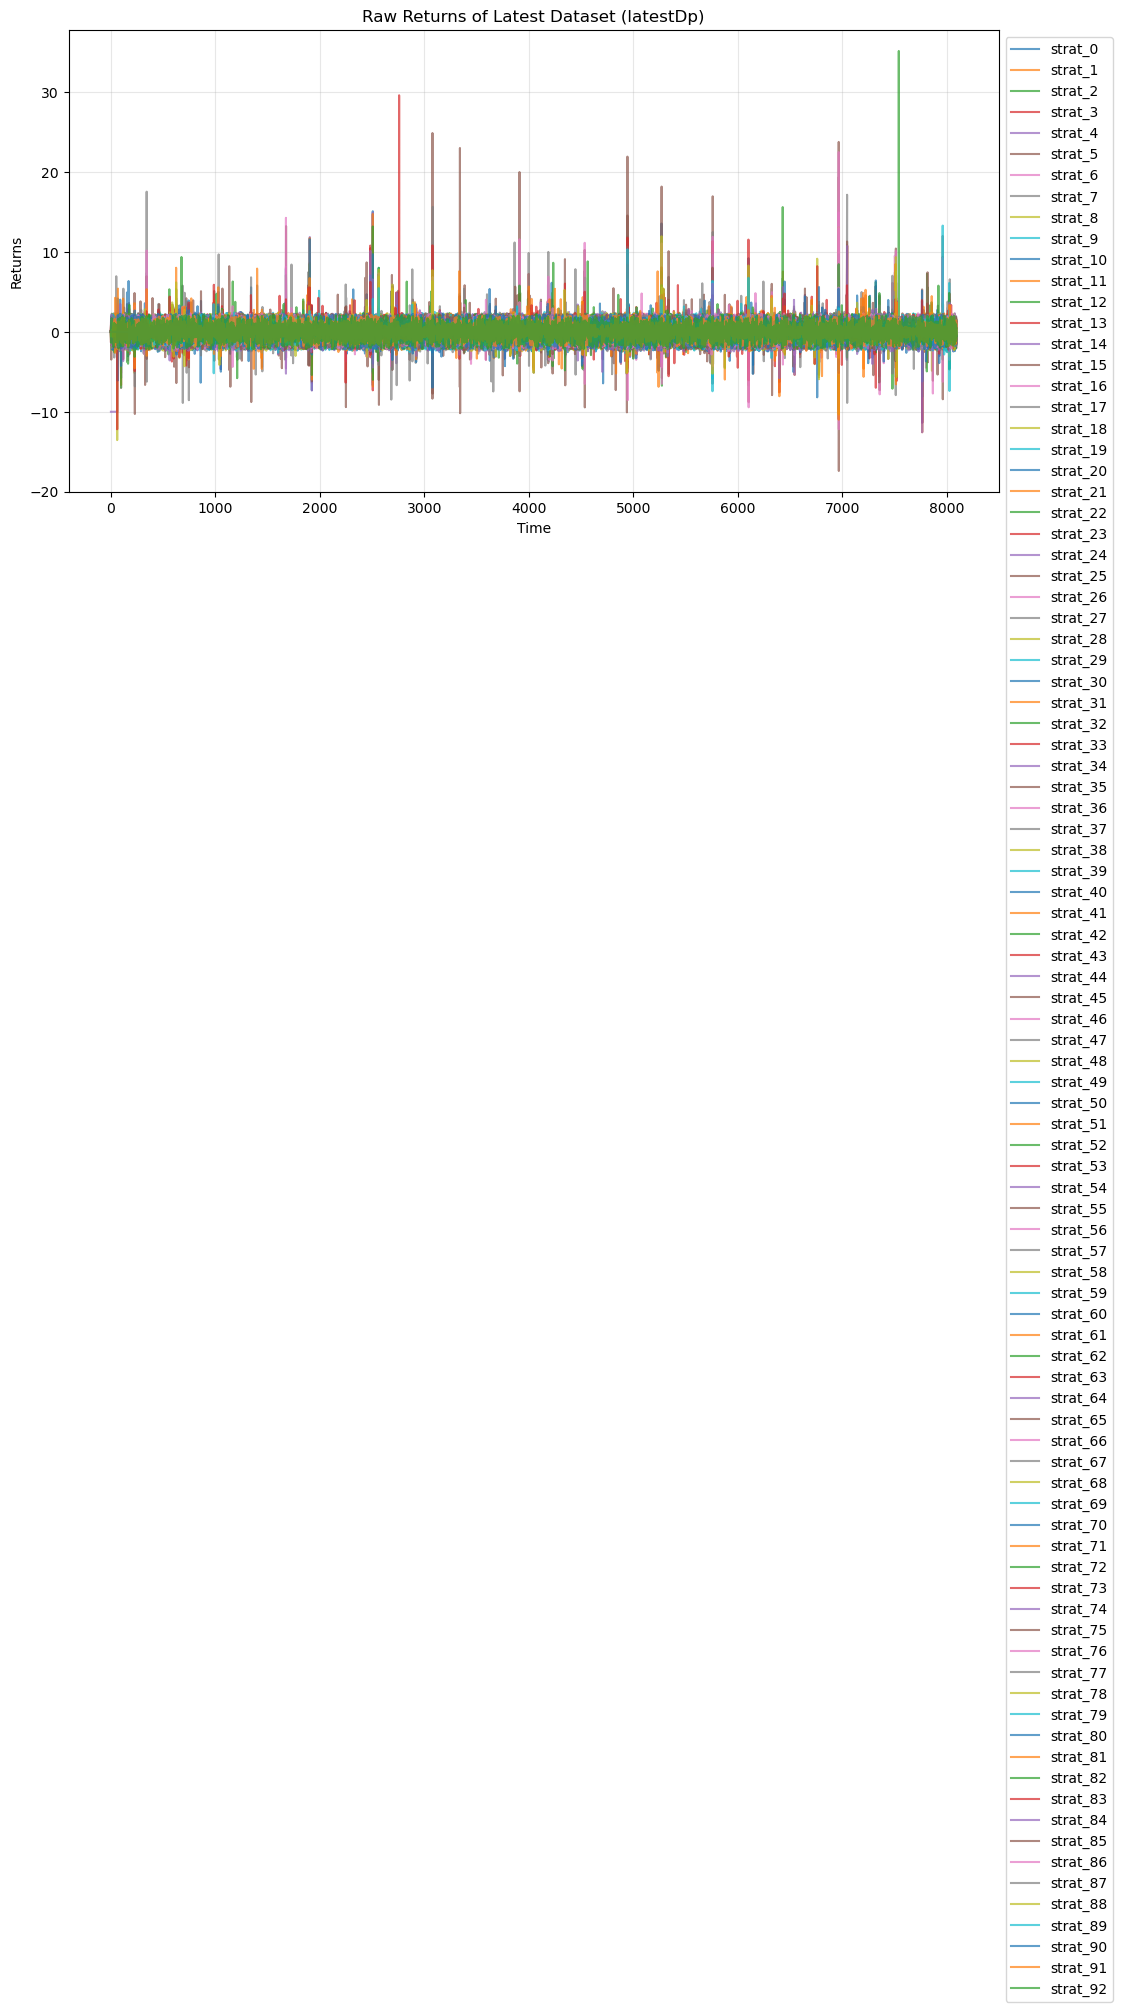

           strat_0      strat_1      strat_2      strat_3      strat_4  \
count  8092.000000  8092.000000  8092.000000  8092.000000  8092.000000   
mean      0.046903    -0.087643    -0.006667     0.049433    -0.012139   
std       0.728413     0.776980     0.811875     0.712310     1.218065   
min      -6.451317    -3.255935    -2.697235    -7.579964   -10.000000   
25%      -0.326651    -0.579823    -0.535582    -0.337010    -0.499132   
50%       0.026998    -0.068291    -0.012049     0.014600     0.047135   
75%       0.379893     0.387345     0.518906     0.411501     0.609542   
max      13.571672     7.365662     5.881561    10.929815     2.575431   

           strat_5      strat_6      strat_7      strat_8      strat_9  ...  \
count  8092.000000  8092.000000  8092.000000  8092.000000  8092.000000  ...   
mean      0.043214    -0.011216     0.064906     0.058767     0.021168  ...   
std       0.725535     0.825693     0.873939     0.761134     0.788699  ...   
min     -10.94019

In [150]:
import matplotlib.pyplot as plt

# Assuming latestDp is your DataFrame with the latest returns data

plt.figure(figsize=(12, 6))
plt.plot(latestDp.index, latestDp, alpha=0.7)
plt.title("Raw Returns of Latest Dataset (latestDp)")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend(latestDp.columns, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print(latestDp.describe())

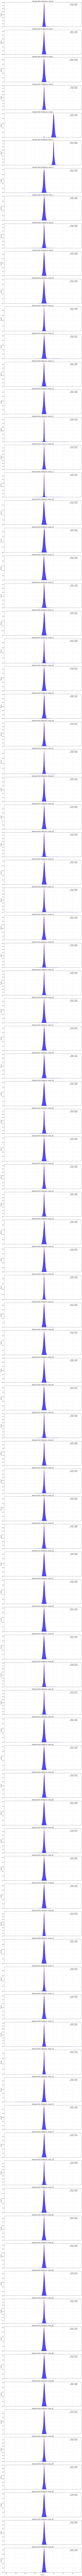

           strat_0      strat_1      strat_2      strat_3      strat_4  \
count  8092.000000  8092.000000  8092.000000  8092.000000  8092.000000   
mean      0.034670    -0.086971    -0.004811     0.034200     9.984391   
std       0.884652     0.922422     0.833897     0.800541     1.237938   
min     -15.624890   -37.758579    -5.492712    -7.967068     0.000000   
25%      -0.347490    -0.585234    -0.536590    -0.351837     9.494550   
50%       0.021173    -0.068078    -0.011352     0.008488    10.045848   
75%       0.379613     0.392659     0.523704     0.413984    10.612600   
max      13.571672     7.365662     5.881561    10.929815    15.747117   

           strat_5      strat_6      strat_7      strat_8      strat_9  ...  \
count  8092.000000  8092.000000  8092.000000  8092.000000  8092.000000  ...   
mean     10.030184    -0.014818     0.063071     0.044966     0.019879  ...   
std       0.846831     0.881270     0.890227     0.899048     0.809819  ...   
min      -0.94019

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming latestDp is your DataFrame with the latest returns data

# Set up the plot grid: one plot per strategy
num_strategies = latestDp.shape[1]
fig, axes = plt.subplots(num_strategies, 1, figsize=(12, 4 * num_strategies), sharex=True)

# Iterate through each strategy to plot its density
for i, column in enumerate(latestDp.columns):
    sns.kdeplot(
        data=latestDp[column],
        ax=axes[i] if num_strategies > 1 else axes,  # Handle case of single strategy
        fill=True,  # Filled density plot
        color='blue',  # Customize color as needed
        alpha=0.7
    )
    
    # Add a vertical line for the mean
    mean_value = latestDp[column].mean()
    axes[i].axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
    
    # Add text for mean and standard deviation
    std_value = latestDp[column].std()
    axes[i].text(0.95, 0.95, f'Mean: {mean_value:.4f}\nStd Dev: {std_value:.4f}', 
                 transform=axes[i].transAxes, ha='right', va='top',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    axes[i].set_title(f"Density Plot of Returns: {column}", fontsize=14)
    axes[i].set_xlabel('Returns')
    axes[i].set_ylabel('Density')
    axes[i].grid(True, alpha=0.3)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

# Print summary statistics
print(latestDp.describe())

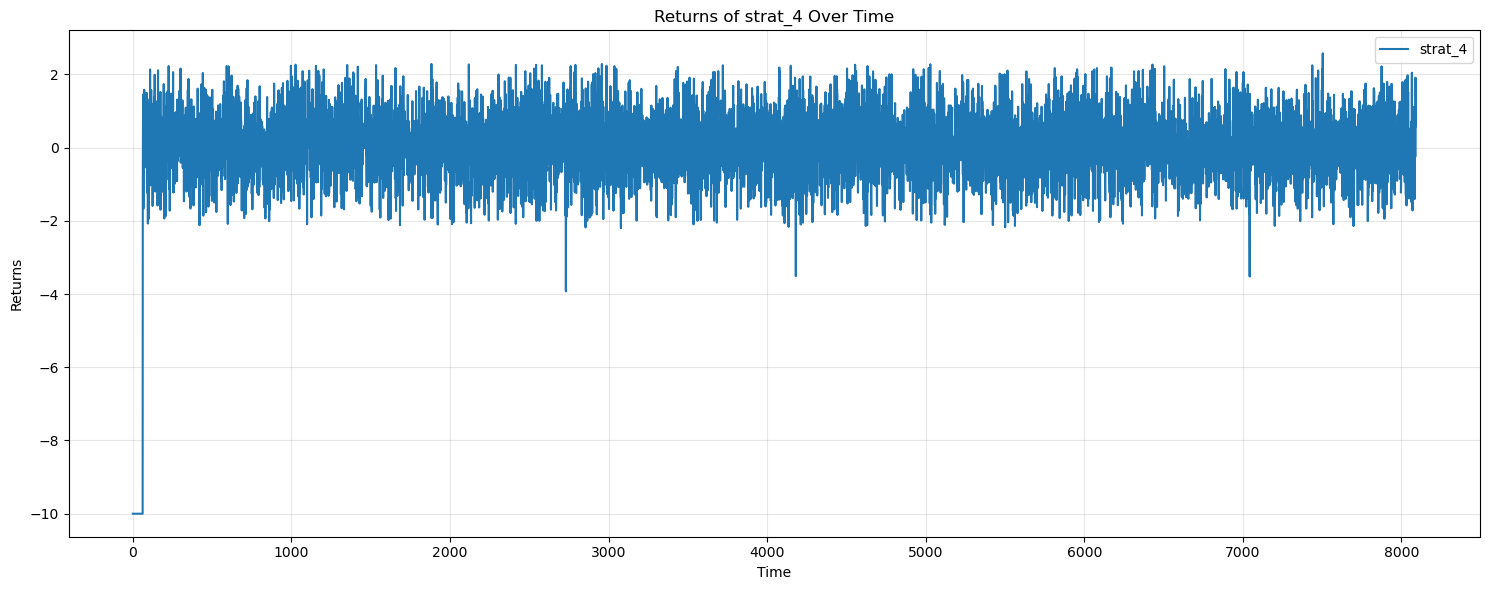

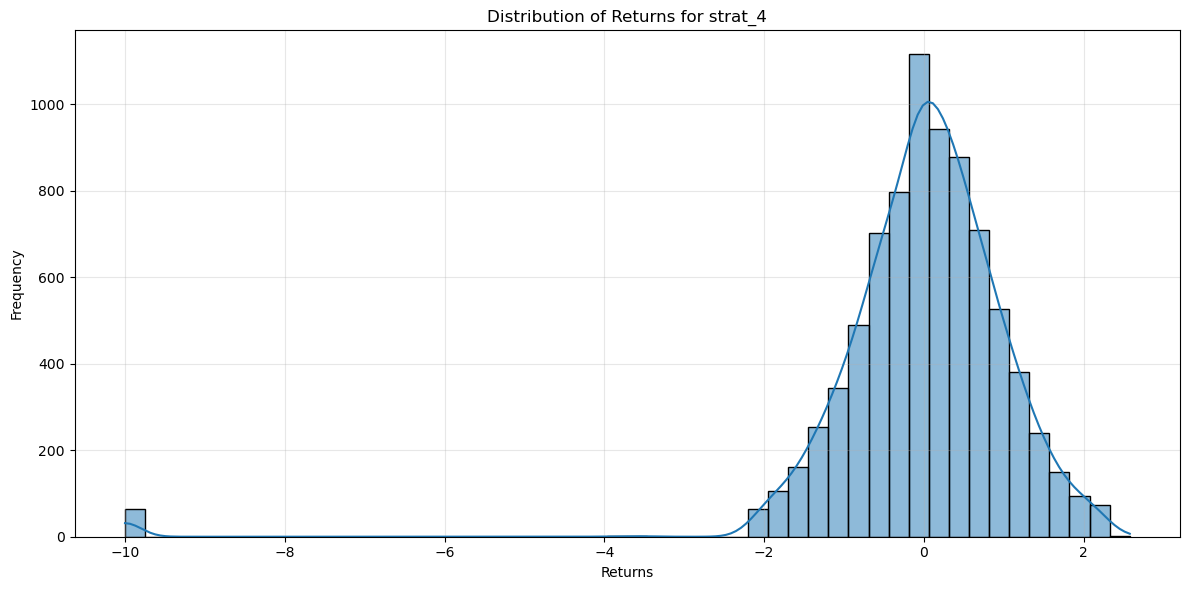

count    8092.000000
mean       -0.012139
std         1.218065
min       -10.000000
25%        -0.499132
50%         0.047135
75%         0.609542
max         2.575431
Name: strat_4, dtype: float64

Potential outlier in strat_4:
Value: 2.5754312352498836
Index: 7504

Data points around the outlier:
7499    0.236802
7500   -0.163756
7501    2.144619
7502    2.144619
7503    2.144619
7504    2.575431
7505    0.931064
7506    0.931064
7507    0.931064
7508    0.283264
7509    0.283264
Name: strat_4, dtype: float64


In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming latestDp is your DataFrame and it contains 'strat_4'

# Time series plot
plt.figure(figsize=(15, 6))
plt.plot(latestDp.index, latestDp['strat_4'], label='strat_4')
plt.title("Returns of strat_4 Over Time")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Histogram and KDE plot
plt.figure(figsize=(12, 6))
sns.histplot(latestDp['strat_4'], kde=True, bins=50)
plt.title("Distribution of Returns for strat_4")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(latestDp['strat_4'].describe())

# Find the outlier (assuming it's the max value)
outlier_value = latestDp['strat_4'].max()
outlier_index = latestDp['strat_4'].idxmax()

print(f"\nPotential outlier in strat_4:")
print(f"Value: {outlier_value}")
print(f"Index: {outlier_index}")

# Optional: Print the surrounding data points
print("\nData points around the outlier:")
print(latestDp['strat_4'].loc[outlier_index-5:outlier_index+5])

In [154]:
(latestDp['strat_4'] == -10).sum()

63

In [156]:
latestDp['strat_4'] = latestDp['strat_4'].replace(-10, 0)

In [158]:
(latestDp['strat_4'] == -10).sum()

0

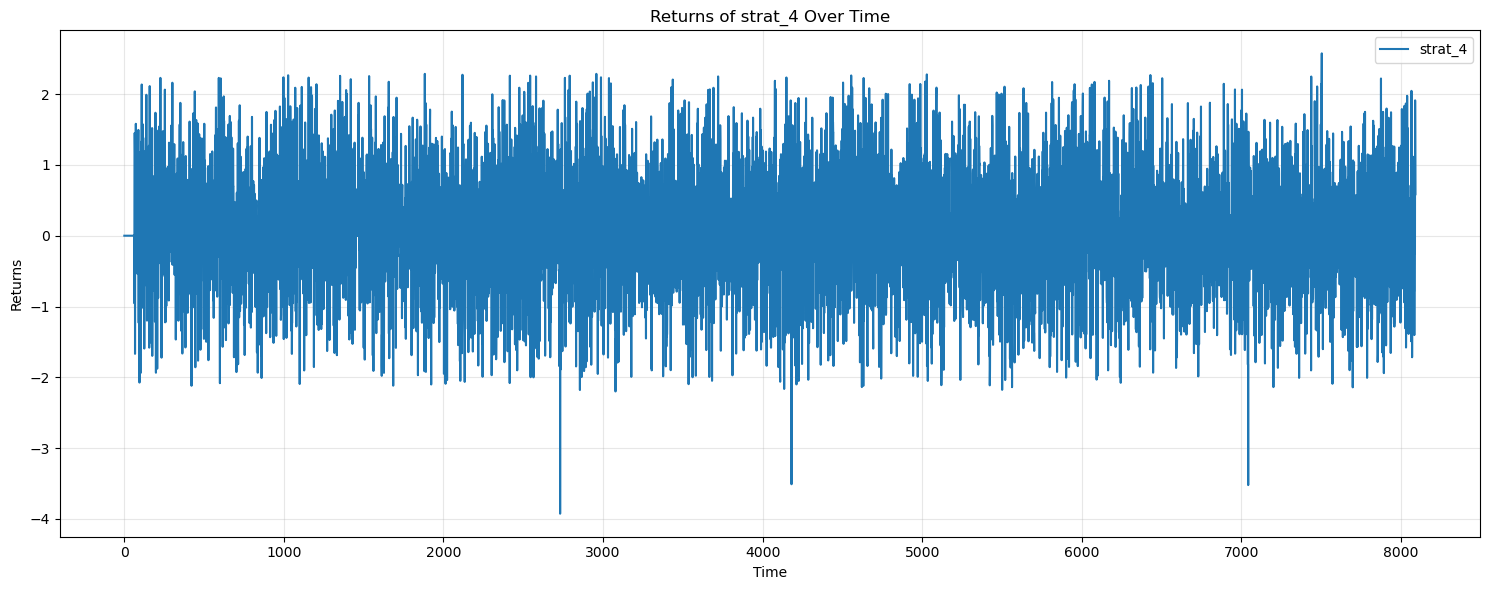

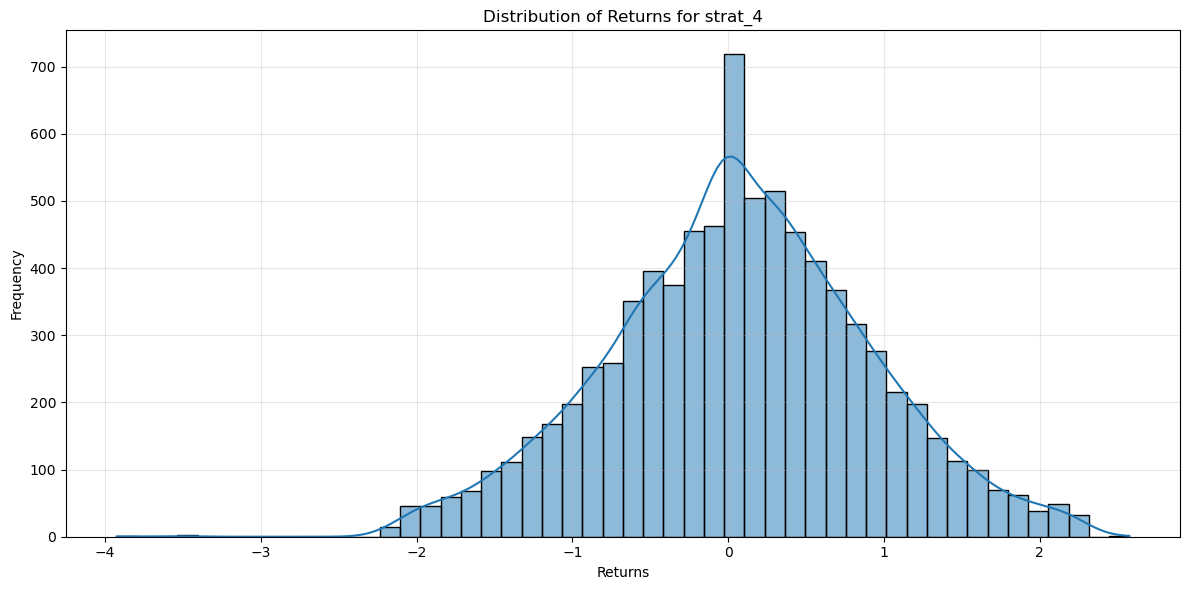

count    8092.000000
mean        0.065716
std         0.837178
min        -3.926125
25%        -0.475482
50%         0.047135
75%         0.609542
max         2.575431
Name: strat_4, dtype: float64

Potential outlier in strat_4:
Value: 2.5754312352498836
Index: 7504

Data points around the outlier:
7499    0.236802
7500   -0.163756
7501    2.144619
7502    2.144619
7503    2.144619
7504    2.575431
7505    0.931064
7506    0.931064
7507    0.931064
7508    0.283264
7509    0.283264
Name: strat_4, dtype: float64


In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming latestDp is your DataFrame and it contains 'strat_4'

# Time series plot
plt.figure(figsize=(15, 6))
plt.plot(latestDp.index, latestDp['strat_4'], label='strat_4')
plt.title("Returns of strat_4 Over Time")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Histogram and KDE plot
plt.figure(figsize=(12, 6))
sns.histplot(latestDp['strat_4'], kde=True, bins=50)
plt.title("Distribution of Returns for strat_4")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(latestDp['strat_4'].describe())

# Find the outlier (assuming it's the max value)
outlier_value = latestDp['strat_4'].max()
outlier_index = latestDp['strat_4'].idxmax()

print(f"\nPotential outlier in strat_4:")
print(f"Value: {outlier_value}")
print(f"Index: {outlier_index}")

# Optional: Print the surrounding data points
print("\nData points around the outlier:")
print(latestDp['strat_4'].loc[outlier_index-5:outlier_index+5])

New Optimized Strategy Allocations:
strat_0: 3.79%
strat_8: 1.20%
strat_12: 2.24%
strat_15: 0.82%
strat_21: 10.00%
strat_22: 4.00%
strat_25: 2.82%
strat_29: 2.69%
strat_31: 5.13%
strat_32: 7.03%
strat_37: 5.91%
strat_38: 4.49%
strat_40: 10.00%
strat_42: 1.14%
strat_45: 0.84%
strat_48: 0.26%
strat_52: 6.89%
strat_54: 9.68%
strat_64: 1.59%
strat_67: 3.94%
strat_71: 9.71%
strat_73: 4.84%
strat_77: 0.98%


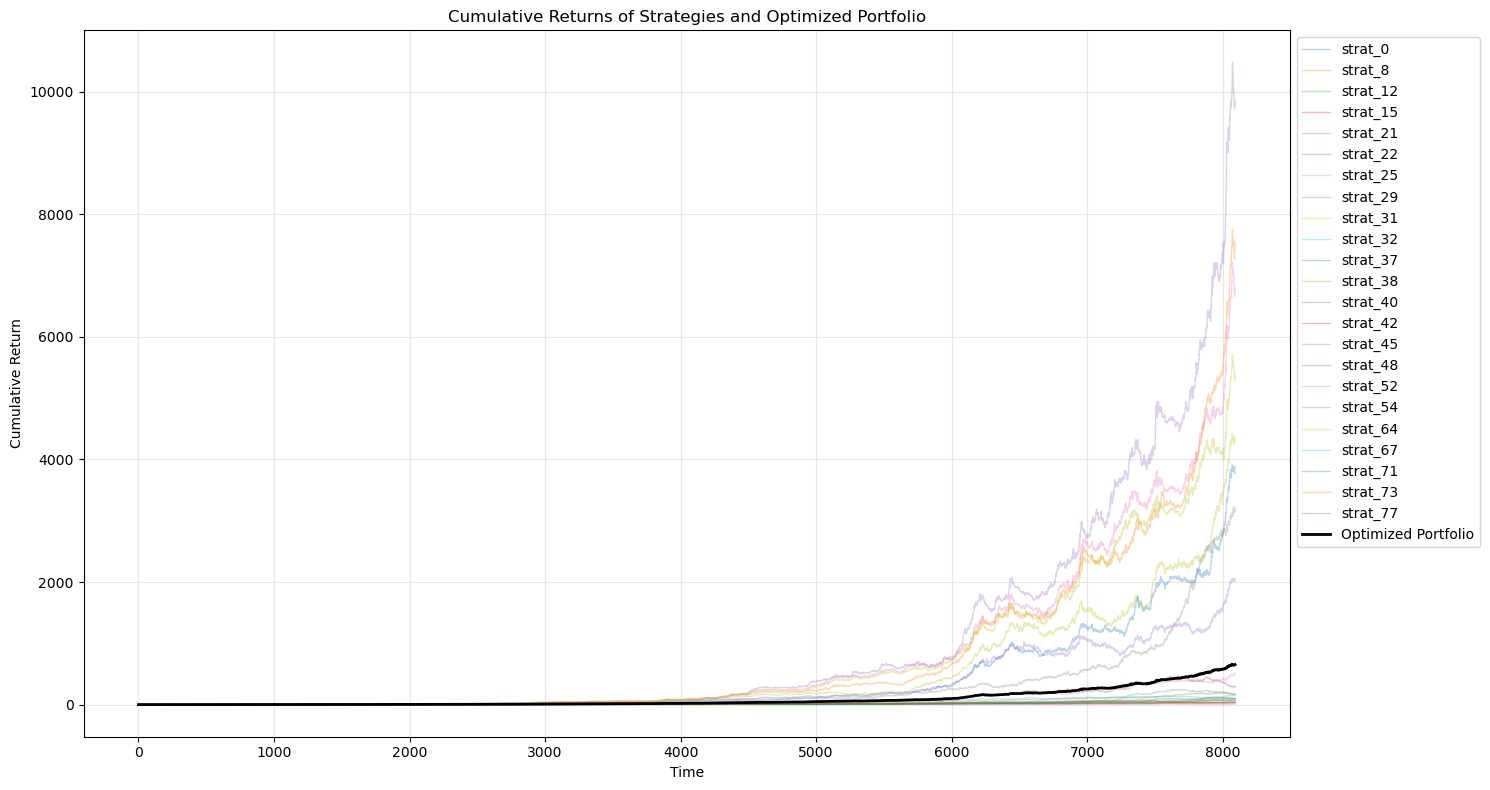


Optimized Portfolio Performance Metrics:
Total Return: 65179.39%
Annualized Return: 22.37%
Annualized Volatility: 5.32%
Sharpe Ratio: 3.27


In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming latestDp is your DataFrame with cleaned returns data

# Step 1: Mean-Variance Optimization

# Calculate expected returns and covariance
expected_returns = latestDp.mean()
cov_matrix = latestDp.cov()

# Define the objective function (negative Sharpe ratio)
def objective(weights):
    portfolio_return = np.sum(expected_returns * weights) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized volatility
    return -(portfolio_return - 0.05 * 100) / portfolio_volatility  # Negative Sharpe ratio with 5% risk-free rate

# Define constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 0.1) for asset in range(len(latestDp.columns)))  # Each weight between 0 and 10%

# Perform optimization
num_assets = len(latestDp.columns)
initial_weights = np.array([1/num_assets] * num_assets)
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Get optimized weights
optimized_weights = result.x

# Step 2: Get new allocations
new_allocations = dict(zip(latestDp.columns, optimized_weights))

print("New Optimized Strategy Allocations:")
for strat, weight in new_allocations.items():
    if weight > 0.0001:  # Only print non-zero allocations
        print(f"{strat}: {weight*100:.2f}%")

# Step 3: Backtest the new allocations

# Calculate cumulative returns for all strategies
cumulative_returns = (1 + latestDp/100).cumprod()

# Calculate portfolio returns
portfolio_returns = pd.Series(0, index=latestDp.index)
for strat, weight in new_allocations.items():
    portfolio_returns += latestDp[strat] * weight

# Calculate cumulative portfolio returns
cumulative_portfolio_returns = (1 + portfolio_returns/100).cumprod()

# Plotting
plt.figure(figsize=(15, 8))

# Plot individual strategy returns
for column in cumulative_returns.columns:
    if new_allocations[column] > 0.0001:  # Only plot strategies with non-zero allocation
        plt.plot(cumulative_returns.index, cumulative_returns[column], label=column, linewidth=1, alpha=0.3)

# Plot portfolio returns
plt.plot(cumulative_returns.index, cumulative_portfolio_returns, label='Optimized Portfolio', linewidth=2, color='black')

plt.title("Cumulative Returns of Strategies and Optimized Portfolio")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.3)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print portfolio performance metrics
total_return = (cumulative_portfolio_returns.iloc[-1] - 1) * 100
annualized_return = ((1 + total_return/100) ** (252/len(cumulative_portfolio_returns)) - 1) * 100
annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)

# Calculate Sharpe Ratio with 5% risk-free rate
risk_free_rate = 0.05  # 5% risk-free rate
sharpe_ratio = (annualized_return - risk_free_rate * 100) / annualized_volatility

print(f"\nOptimized Portfolio Performance Metrics:")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

C:\Users\Thani\AppData\Local\Temp\ipykernel_25828\173033686.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  publicData['strat_4'].replace(-10, 0, inplace=True)
C:\Users\Thani\AppData\Local\Temp\ipykernel_25828\173033686.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  publicData.fillna(method='bfill', inplace=True)


New Optimized Strategy Allocations:
strat_0: 0.13%
strat_12: 2.59%
strat_21: 10.00%
strat_22: 6.99%
strat_29: 2.81%
strat_31: 8.56%
strat_32: 3.95%
strat_37: 7.78%
strat_38: 3.48%
strat_40: 3.71%
strat_45: 3.20%
strat_48: 1.77%
strat_51: 0.12%
strat_52: 8.72%
strat_54: 10.00%
strat_64: 5.51%
strat_67: 4.98%
strat_71: 5.32%
strat_77: 0.27%
strat_95: 0.10%
strat_97: 10.00%


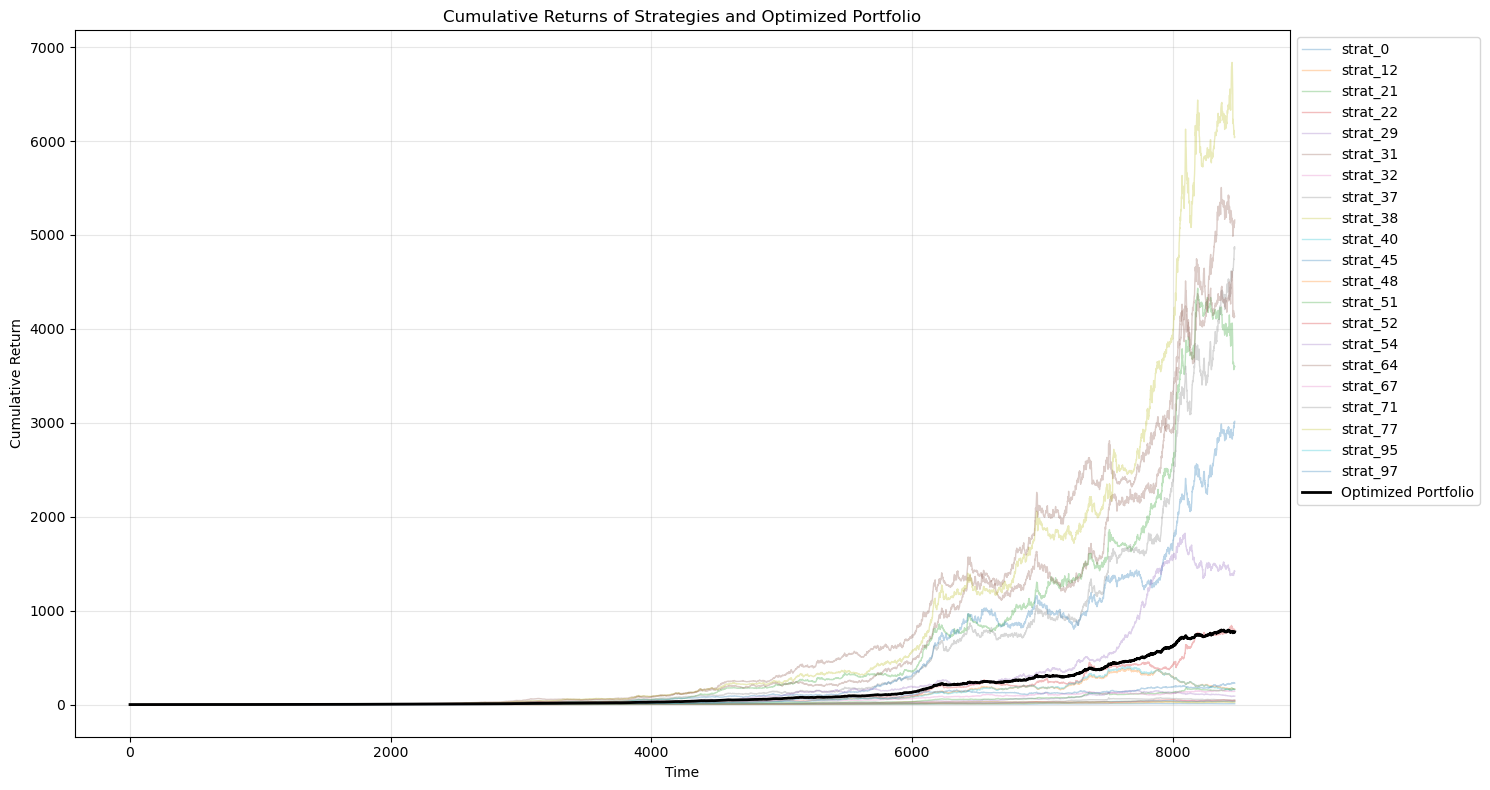


Optimized Portfolio Performance Metrics:
Total Return: 77537.26%
Annualized Return: 21.88%
Annualized Volatility: 6.46%
Sharpe Ratio: 2.61


In [230]:
import cryptpandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Load the encrypted data
publicData = cryptpandas.read_encrypted(path="./release_8475.crypt", password='IToOiV72S4vRSmcn')

# Step 2: Fill NA values with 0
publicData = publicData.fillna(0)

# Step 3: Replace inf values with 0
publicData[publicData == np.inf] = 0 
publicData[publicData == -np.inf] = 0 

# Step 4: Shift strat_4 and strat_5 by -10
if 'strat_4' in publicData.columns:
    publicData['strat_4'] -= 10
if 'strat_5' in publicData.columns:
    publicData['strat_5'] -= 10

# Replace -10 values in strat_4 with 0
publicData['strat_4'].replace(-10, 0, inplace=True)

# Step 5: Remove outliers using IQR method
def iqr_outlier_detection(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

# Detect outliers using IQR method and replace them with the previous value
outliers = publicData.apply(iqr_outlier_detection)
for col in publicData.columns:
    if publicData[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
        outlier_indices = outliers[col]
        publicData.loc[outlier_indices, col] = publicData[col].shift(1)[outlier_indices]

# Final cleaned dataset (backfill any remaining NaNs)
publicData.fillna(method='bfill', inplace=True)

# Step 6: Mean-Variance Optimization to maximize Sharpe ratio
expected_returns = publicData.mean()
cov_matrix = publicData.cov()

def objective(weights):
    portfolio_return = np.sum(expected_returns * weights) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized volatility
    return -(portfolio_return - 0.05 * 100) / portfolio_volatility  # Negative Sharpe ratio with a risk-free rate of 5%

# Define constraints and bounds for optimization
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 0.1) for asset in range(len(publicData.columns)))  # Each weight between 0 and 10%

# Perform optimization
num_assets = len(publicData.columns)
initial_weights = np.array([1/num_assets] * num_assets)
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Get optimized weights and create allocation dictionary
optimized_weights = result.x
new_allocations = dict(zip(publicData.columns, optimized_weights))

# Output the allocations
print("New Optimized Strategy Allocations:")
for strat, weight in new_allocations.items():
    if weight > 0.0001:  # Only print non-zero allocations
        print(f"{strat}: {weight*100:.2f}%")

# Step 7: Backtest the new allocations

# Calculate cumulative returns for all strategies
cumulative_returns = (1 + publicData / 100).cumprod()

# Calculate portfolio returns based on optimized weights
portfolio_returns = pd.Series(0, index=publicData.index)
for strat, weight in new_allocations.items():
    portfolio_returns += publicData[strat] * weight

# Calculate cumulative portfolio returns
cumulative_portfolio_returns = (1 + portfolio_returns / 100).cumprod()

# Plotting cumulative returns of the optimized portfolio and strategies (optional visualization)
plt.figure(figsize=(15, 8))

# Plot individual strategy returns (optional)
for column in cumulative_returns.columns:
    if new_allocations[column] > 0.0001:  
        plt.plot(cumulative_returns.index, cumulative_returns[column], label=column, linewidth=1, alpha=0.3)

# Plot portfolio returns
plt.plot(cumulative_returns.index, cumulative_portfolio_returns, label='Optimized Portfolio', linewidth=2, color='black')

plt.title("Cumulative Returns of Strategies and Optimized Portfolio")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.3)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.show()

# Calculate and print portfolio performance metrics
total_return = (cumulative_portfolio_returns.iloc[-1] - 1) * 100
annualized_return = ((1 + total_return / 100) ** (252 / len(cumulative_portfolio_returns)) - 1) * 100
annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)

# Calculate Sharpe Ratio with a risk-free rate of 5%
risk_free_rate = 0.05  
sharpe_ratio = (annualized_return - risk_free_rate * 100) / annualized_volatility

print(f"\nOptimized Portfolio Performance Metrics:")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

In [228]:
# Assuming new_allocations is already defined with the optimized strategy allocations

# Create a dictionary for submission
submission_dict = {}

# Add strategy allocations to the dictionary
for strat, weight in new_allocations.items():
    if weight > 0.0001:  # Only include non-zero allocations
        submission_dict[strat] = weight

# Add team name and passcode at the bottom
submission_dict['team_name'] = 'MKT'
submission_dict['passcode'] = 'knacks'

# Output the submission dictionary in the desired format without tab indentation
formatted_submission = "{\n" + ',\n '.join(f"'{key}': {value}" for key, value in submission_dict.items()) + "\n}"

print(formatted_submission)

{
'strat_0': 0.0012680843093946807,
 'strat_12': 0.025905014926388716,
 'strat_21': 0.0999999999999972,
 'strat_22': 0.0699305143105149,
 'strat_29': 0.028067293528342717,
 'strat_31': 0.08564585010734671,
 'strat_32': 0.03949935308543483,
 'strat_37': 0.07775842815558104,
 'strat_38': 0.03475473541360673,
 'strat_40': 0.03714603915741743,
 'strat_45': 0.03203528849513493,
 'strat_48': 0.01772152201427307,
 'strat_51': 0.0012468703342046927,
 'strat_52': 0.08723336575837412,
 'strat_54': 0.099999999999996,
 'strat_64': 0.055128741216798845,
 'strat_67': 0.04980462224813522,
 'strat_71': 0.05315492177613816,
 'strat_77': 0.002728252310991606,
 'strat_95': 0.0009711028519422311,
 'strat_97': 0.09999999999999974,
 'team_name': MKT,
 'passcode': knacks
}


In [232]:
# Assuming new_allocations is already defined with the optimized strategy allocations

# Calculate the total allocation
total_allocation = sum(new_allocations.values())

# Check if the total allocation sums to 1
if np.isclose(total_allocation, 1.0):
    print(f"The total allocation sums to {total_allocation:.2f}, which is correct.")
else:
    print(f"Error: The total allocation sums to {total_allocation:.2f}, but it should sum to 1.00.")

The total allocation sums to 1.00, which is correct.
